# This notebook simulates a simple mountain destroyed by rainfall and glaciers


figured out that scipy zoom really makes the figures shine


## Principles:

* The land starts as rock

* Rain falls on a random set of figures at every step

* Rain flows downhill, and can barely scratch the rock, but drags the gravel along

* The temperature is determined by height

* Rain freezes to glacier if it's below zero

* Glaciers destroy the rock into gravel below them

* Glaciers flow downhill slowly

* When above zero, a glacier melts at a constant rate


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Making a mountainside

In [2]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

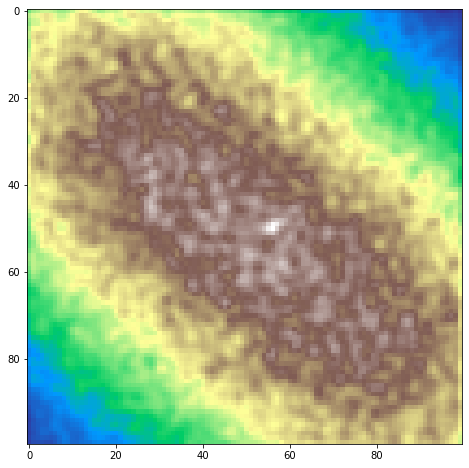

In [51]:
samples1 = np.random.multivariate_normal((1.7, 1.8), cov=np.eye(2), size=int(2.4e6))
samples2 = np.random.multivariate_normal((0.4, 0.3), cov=np.eye(2), size=int(2.4e6))
# samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
# samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
# samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2))

bins = np.linspace(0, 2, 104)

bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0] * 4
land = convolve_map(land, 1, which="gauss")
land = land[1:-2, 1:-1]

lmax = land.max()
land = (land / lmax)**2. * lmax
land *= 5000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain)

In [57]:
zland = ndimage.zoom(land, 2)

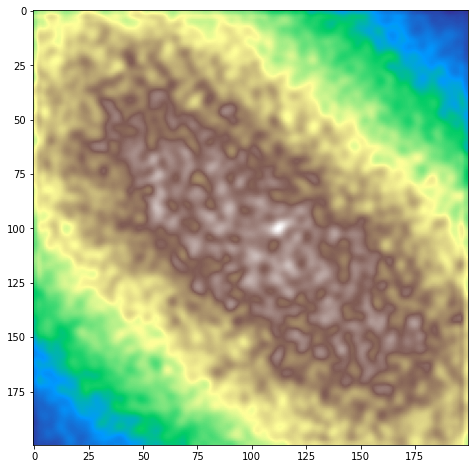

In [58]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(zland, cmap=plt.cm.terrain)

In [59]:
land.min()

734.9132549543912

# Erosion model of the mountain side

In [60]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

def null_edges(arr):
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [61]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [62]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, fraction=0.2, seed=10):
        """
        This is adds new rain water to the water canvas
    
        """
        self.layers = np.sort(("water",))
        self.key = "water"
        self.rainfall = rainfall
        self.fraction = fraction
        self.rng = np.random.RandomState(seed)
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        rmax = 100
        rpiv = rmax * (1 - self.fraction)
        rainmap = np.random.random(size=water_local.shape) * rmax
        rainmap[rainmap <= rpiv] = 0.
        rainmap[rainmap > rpiv] = self.rainfall
        
        water_local += rainmap
        
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        


In [63]:
   
class WaterGravelFlow(FlowRule):
    def __init__(self, altitude=10000, water_flow_rate=0.5, land_coerosion_rate=0.1,
                 drag_coeff=0.1, gravel_factor=4, flow_limit=10.):
        """
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("rock", "gravel" , "water"))
        self.wkey = "water"
        self.lkey = "rock"
        self.gkey = "gravel"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        self.drag_coeff = drag_coeff
        self.gravel_factor = gravel_factor
        self.altitude = altitude
                
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        rock_local = cell.canvases[self.lkey]
        rock_shifted = cell.shifted_canvases[self.lkey]
        
        gravel_local = cell.canvases[self.gkey]
        gravel_shifted = cell.shifted_canvases[self.gkey]
        
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]
        
        height_local = rock_local + gravel_local + water_local
        height_shifted = rock_shifted + gravel_shifted + water_shifted

        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        water_local = null_edges(water_local) # This models the part where water flows out of the canvas
        # no more land can outflow than there is difference
        # Due to the megaoutflow approximation, the water height can be VERY high, this means we need to rationalize
        # The amount of land drag possible to an actual sensible maximum
        
        # The rock must only eroded if there is no more gravel left... This is a really curious nonlinearity
        
        # 2) the gravel flows
        gflow_limit = np.sqrt(gravel_local) * self.drag_coeff * self.gravel_factor
        ii = np.where(gflow_limit > 0.1 * gravel_local)
        gflow_limit[ii] = 0.1 * gravel_local[ii]        
        gflow_limit = np.array([gflow_limit, ] * 4) / 4.
        outflow_g = outflow_w * self.land_coerosion_rate * self.gravel_factor
        ii = outflow_g > (gflow_limit)
        outflow_g[ii] = gflow_limit[ii]        
        gravel_local = self.calc_flows(gravel_local, outflow_g, cell)

        
        # 3) The rock erodes
        # we have to establish the local gravel coverage
        # The rock is eroded by the flow of water
        lflow_limit = np.sqrt(rock_local) * self.drag_coeff
        ii = np.where(lflow_limit > 0.1 * rock_local)
        lflow_limit[ii] = 0.1 * rock_local[ii]
        ii = np.where(gravel_local > 0)
        lflow_limit[ii] = 0. # This means the rock will never erode if its covered by gravel
        lflow_limit = np.array([lflow_limit, ] * 4) / 4.
#         lflow_limit = np.array([rock_local * self.drag_coeff,] * 4) / 4 # limit how much land can be dragged at each point
        
        # in megaoutflow, water can pile up really high, this must be regularized
        outflow_l = outflow_w * self.land_coerosion_rate
        ii = outflow_l > (lflow_limit)
        outflow_l[ii] = lflow_limit[ii]        
        
        rock_local -= outflow_l.sum(axis=0)    
        # The land is flown into gravel, not into land
        
        # 4) the gravel flows again to receive the erosion of the rock
        gravel_local += self._calc_flows(gravel_local, outflow_l, cell)

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: rock_local, self.gkey: gravel_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    


In [67]:
rules = (
    RainFall(rainfall=0.1, fraction=0.2),
    WaterGravelFlow(land_coerosion_rate=0.05, water_flow_rate=0.9, drag_coeff=4, gravel_factor=2),
)
wmap = np.zeros(shape=zland.shape)
gmap = np.zeros(shape=zland.shape)
initial_maps = {
    "rock": null_edges(zland * 0.8),
    "gravel": null_edges(zland * 0.2),
    "water": null_edges(wmap),
}

In [68]:
cs = CellSpace(initial_maps, rules)
cs.flow(4000, savestep=100)

all_rock = copy.deepcopy(cs.maps["rock"])
all_gravel = copy.deepcopy(cs.maps["gravel"])
all_waters = copy.deepcopy(cs.maps["water"])

0 out of 3999
1 out of 3999
2 out of 3999
3 out of 3999
4 out of 3999
5 out of 3999
6 out of 3999
7 out of 3999
8 out of 3999
9 out of 3999
10 out of 3999
11 out of 3999
12 out of 3999
13 out of 3999
14 out of 3999
15 out of 3999
16 out of 3999
17 out of 3999
18 out of 3999
19 out of 3999
20 out of 3999
21 out of 3999
22 out of 3999
23 out of 3999


/tmp/ipykernel_5482/625500427.py:51: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


24 out of 3999
25 out of 3999
26 out of 3999
27 out of 3999
28 out of 3999
29 out of 3999
30 out of 3999
31 out of 3999
32 out of 3999
33 out of 3999
34 out of 3999
35 out of 3999
36 out of 3999
37 out of 3999
38 out of 3999
39 out of 3999
40 out of 3999
41 out of 3999
42 out of 3999
43 out of 3999
44 out of 3999
45 out of 3999
46 out of 3999
47 out of 3999
48 out of 3999
49 out of 3999
50 out of 3999
51 out of 3999
52 out of 3999
53 out of 3999
54 out of 3999
55 out of 3999
56 out of 3999
57 out of 3999
58 out of 3999
59 out of 3999
60 out of 3999
61 out of 3999
62 out of 3999
63 out of 3999
64 out of 3999
65 out of 3999
66 out of 3999
67 out of 3999
68 out of 3999
69 out of 3999
70 out of 3999
71 out of 3999
72 out of 3999
73 out of 3999
74 out of 3999
75 out of 3999
76 out of 3999
77 out of 3999
78 out of 3999
79 out of 3999
80 out of 3999
81 out of 3999
82 out of 3999
83 out of 3999
84 out of 3999
85 out of 3999
86 out of 3999
87 out of 3999
88 out of 3999
89 out of 3999
90 out of 

546 out of 3999
547 out of 3999
548 out of 3999
549 out of 3999
550 out of 3999
551 out of 3999
552 out of 3999
553 out of 3999
554 out of 3999
555 out of 3999
556 out of 3999
557 out of 3999
558 out of 3999
559 out of 3999
560 out of 3999
561 out of 3999
562 out of 3999
563 out of 3999
564 out of 3999
565 out of 3999
566 out of 3999
567 out of 3999
568 out of 3999
569 out of 3999
570 out of 3999
571 out of 3999
572 out of 3999
573 out of 3999
574 out of 3999
575 out of 3999
576 out of 3999
577 out of 3999
578 out of 3999
579 out of 3999
580 out of 3999
581 out of 3999
582 out of 3999
583 out of 3999
584 out of 3999
585 out of 3999
586 out of 3999
587 out of 3999
588 out of 3999
589 out of 3999
590 out of 3999
591 out of 3999
592 out of 3999
593 out of 3999
594 out of 3999
595 out of 3999
596 out of 3999
597 out of 3999
598 out of 3999
599 out of 3999
600 out of 3999
601 out of 3999
602 out of 3999
603 out of 3999
604 out of 3999
605 out of 3999
606 out of 3999
607 out of 3999
608 out 

1058 out of 3999
1059 out of 3999
1060 out of 3999
1061 out of 3999
1062 out of 3999
1063 out of 3999
1064 out of 3999
1065 out of 3999
1066 out of 3999
1067 out of 3999
1068 out of 3999
1069 out of 3999
1070 out of 3999
1071 out of 3999
1072 out of 3999
1073 out of 3999
1074 out of 3999
1075 out of 3999
1076 out of 3999
1077 out of 3999
1078 out of 3999
1079 out of 3999
1080 out of 3999
1081 out of 3999
1082 out of 3999
1083 out of 3999
1084 out of 3999
1085 out of 3999
1086 out of 3999
1087 out of 3999
1088 out of 3999
1089 out of 3999
1090 out of 3999
1091 out of 3999
1092 out of 3999
1093 out of 3999
1094 out of 3999
1095 out of 3999
1096 out of 3999
1097 out of 3999
1098 out of 3999
1099 out of 3999
1100 out of 3999
1101 out of 3999
1102 out of 3999
1103 out of 3999
1104 out of 3999
1105 out of 3999
1106 out of 3999
1107 out of 3999
1108 out of 3999
1109 out of 3999
1110 out of 3999
1111 out of 3999
1112 out of 3999
1113 out of 3999
1114 out of 3999
1115 out of 3999
1116 out of 39

1541 out of 3999
1542 out of 3999
1543 out of 3999
1544 out of 3999
1545 out of 3999
1546 out of 3999
1547 out of 3999
1548 out of 3999
1549 out of 3999
1550 out of 3999
1551 out of 3999
1552 out of 3999
1553 out of 3999
1554 out of 3999
1555 out of 3999
1556 out of 3999
1557 out of 3999
1558 out of 3999
1559 out of 3999
1560 out of 3999
1561 out of 3999
1562 out of 3999
1563 out of 3999
1564 out of 3999
1565 out of 3999
1566 out of 3999
1567 out of 3999
1568 out of 3999
1569 out of 3999
1570 out of 3999
1571 out of 3999
1572 out of 3999
1573 out of 3999
1574 out of 3999
1575 out of 3999
1576 out of 3999
1577 out of 3999
1578 out of 3999
1579 out of 3999
1580 out of 3999
1581 out of 3999
1582 out of 3999
1583 out of 3999
1584 out of 3999
1585 out of 3999
1586 out of 3999
1587 out of 3999
1588 out of 3999
1589 out of 3999
1590 out of 3999
1591 out of 3999
1592 out of 3999
1593 out of 3999
1594 out of 3999
1595 out of 3999
1596 out of 3999
1597 out of 3999
1598 out of 3999
1599 out of 39

2024 out of 3999
2025 out of 3999
2026 out of 3999
2027 out of 3999
2028 out of 3999
2029 out of 3999
2030 out of 3999
2031 out of 3999
2032 out of 3999
2033 out of 3999
2034 out of 3999
2035 out of 3999
2036 out of 3999
2037 out of 3999
2038 out of 3999
2039 out of 3999
2040 out of 3999
2041 out of 3999
2042 out of 3999
2043 out of 3999
2044 out of 3999
2045 out of 3999
2046 out of 3999
2047 out of 3999
2048 out of 3999
2049 out of 3999
2050 out of 3999
2051 out of 3999
2052 out of 3999
2053 out of 3999
2054 out of 3999
2055 out of 3999
2056 out of 3999
2057 out of 3999
2058 out of 3999
2059 out of 3999
2060 out of 3999
2061 out of 3999
2062 out of 3999
2063 out of 3999
2064 out of 3999
2065 out of 3999
2066 out of 3999
2067 out of 3999
2068 out of 3999
2069 out of 3999
2070 out of 3999
2071 out of 3999
2072 out of 3999
2073 out of 3999
2074 out of 3999
2075 out of 3999
2076 out of 3999
2077 out of 3999
2078 out of 3999
2079 out of 3999
2080 out of 3999
2081 out of 3999
2082 out of 39

2507 out of 3999
2508 out of 3999
2509 out of 3999
2510 out of 3999
2511 out of 3999
2512 out of 3999
2513 out of 3999
2514 out of 3999
2515 out of 3999
2516 out of 3999
2517 out of 3999
2518 out of 3999
2519 out of 3999
2520 out of 3999
2521 out of 3999
2522 out of 3999
2523 out of 3999
2524 out of 3999
2525 out of 3999
2526 out of 3999
2527 out of 3999
2528 out of 3999
2529 out of 3999
2530 out of 3999
2531 out of 3999
2532 out of 3999
2533 out of 3999
2534 out of 3999
2535 out of 3999
2536 out of 3999
2537 out of 3999
2538 out of 3999
2539 out of 3999
2540 out of 3999
2541 out of 3999
2542 out of 3999
2543 out of 3999
2544 out of 3999
2545 out of 3999
2546 out of 3999
2547 out of 3999
2548 out of 3999
2549 out of 3999
2550 out of 3999
2551 out of 3999
2552 out of 3999
2553 out of 3999
2554 out of 3999
2555 out of 3999
2556 out of 3999
2557 out of 3999
2558 out of 3999
2559 out of 3999
2560 out of 3999
2561 out of 3999
2562 out of 3999
2563 out of 3999
2564 out of 3999
2565 out of 39

2989 out of 3999
2990 out of 3999
2991 out of 3999
2992 out of 3999
2993 out of 3999
2994 out of 3999
2995 out of 3999
2996 out of 3999
2997 out of 3999
2998 out of 3999
2999 out of 3999
3000 out of 3999
3001 out of 3999
3002 out of 3999
3003 out of 3999
3004 out of 3999
3005 out of 3999
3006 out of 3999
3007 out of 3999
3008 out of 3999
3009 out of 3999
3010 out of 3999
3011 out of 3999
3012 out of 3999
3013 out of 3999
3014 out of 3999
3015 out of 3999
3016 out of 3999
3017 out of 3999
3018 out of 3999
3019 out of 3999
3020 out of 3999
3021 out of 3999
3022 out of 3999
3023 out of 3999
3024 out of 3999
3025 out of 3999
3026 out of 3999
3027 out of 3999
3028 out of 3999
3029 out of 3999
3030 out of 3999
3031 out of 3999
3032 out of 3999
3033 out of 3999
3034 out of 3999
3035 out of 3999
3036 out of 3999
3037 out of 3999
3038 out of 3999
3039 out of 3999
3040 out of 3999
3041 out of 3999
3042 out of 3999
3043 out of 3999
3044 out of 3999
3045 out of 3999
3046 out of 3999
3047 out of 39

3472 out of 3999
3473 out of 3999
3474 out of 3999
3475 out of 3999
3476 out of 3999
3477 out of 3999
3478 out of 3999
3479 out of 3999
3480 out of 3999
3481 out of 3999
3482 out of 3999
3483 out of 3999
3484 out of 3999
3485 out of 3999
3486 out of 3999
3487 out of 3999
3488 out of 3999
3489 out of 3999
3490 out of 3999
3491 out of 3999
3492 out of 3999
3493 out of 3999
3494 out of 3999
3495 out of 3999
3496 out of 3999
3497 out of 3999
3498 out of 3999
3499 out of 3999
3500 out of 3999
3501 out of 3999
3502 out of 3999
3503 out of 3999
3504 out of 3999
3505 out of 3999
3506 out of 3999
3507 out of 3999
3508 out of 3999
3509 out of 3999
3510 out of 3999
3511 out of 3999
3512 out of 3999
3513 out of 3999
3514 out of 3999
3515 out of 3999
3516 out of 3999
3517 out of 3999
3518 out of 3999
3519 out of 3999
3520 out of 3999
3521 out of 3999
3522 out of 3999
3523 out of 3999
3524 out of 3999
3525 out of 3999
3526 out of 3999
3527 out of 3999
3528 out of 3999
3529 out of 3999
3530 out of 39

3967 out of 3999
3968 out of 3999
3969 out of 3999
3970 out of 3999
3971 out of 3999
3972 out of 3999
3973 out of 3999
3974 out of 3999
3975 out of 3999
3976 out of 3999
3977 out of 3999
3978 out of 3999
3979 out of 3999
3980 out of 3999
3981 out of 3999
3982 out of 3999
3983 out of 3999
3984 out of 3999
3985 out of 3999
3986 out of 3999
3987 out of 3999
3988 out of 3999
3989 out of 3999
3990 out of 3999
3991 out of 3999
3992 out of 3999
3993 out of 3999
3994 out of 3999
3995 out of 3999
3996 out of 3999
3997 out of 3999
3998 out of 3999
3999 out of 3999


/tmp/ipykernel_5482/3031268836.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


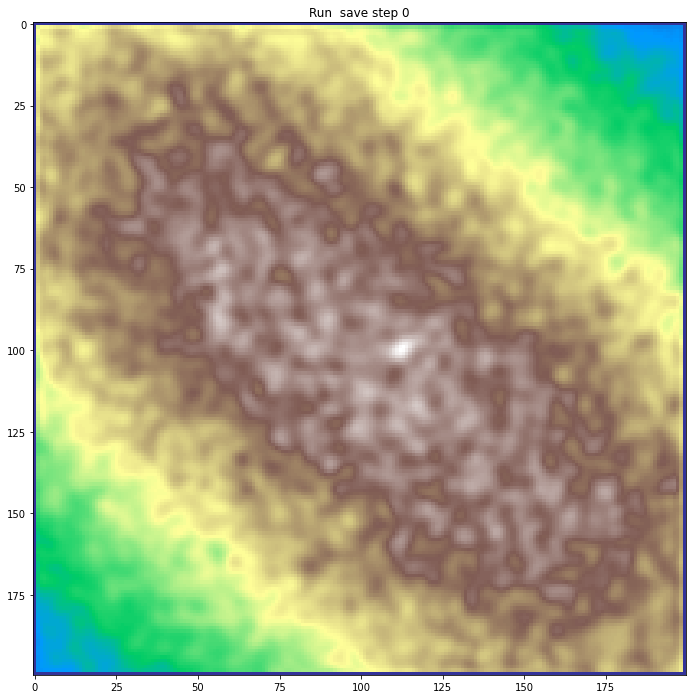

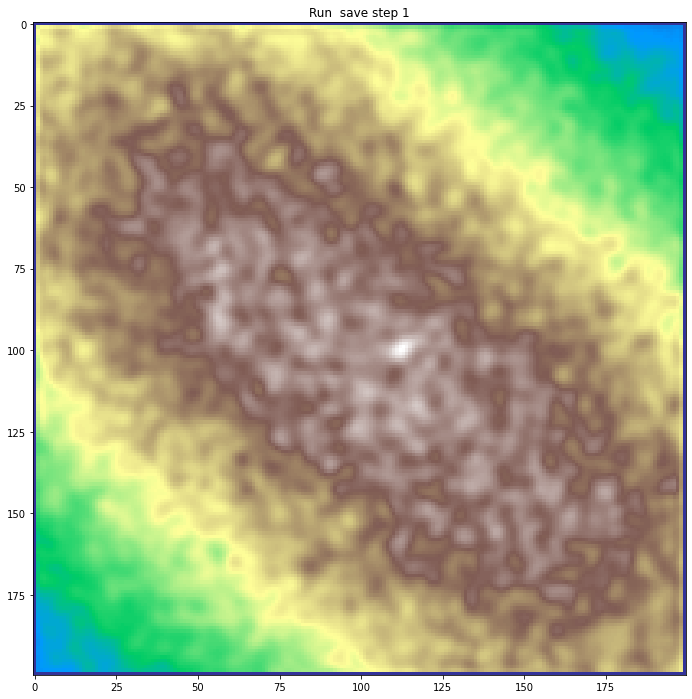

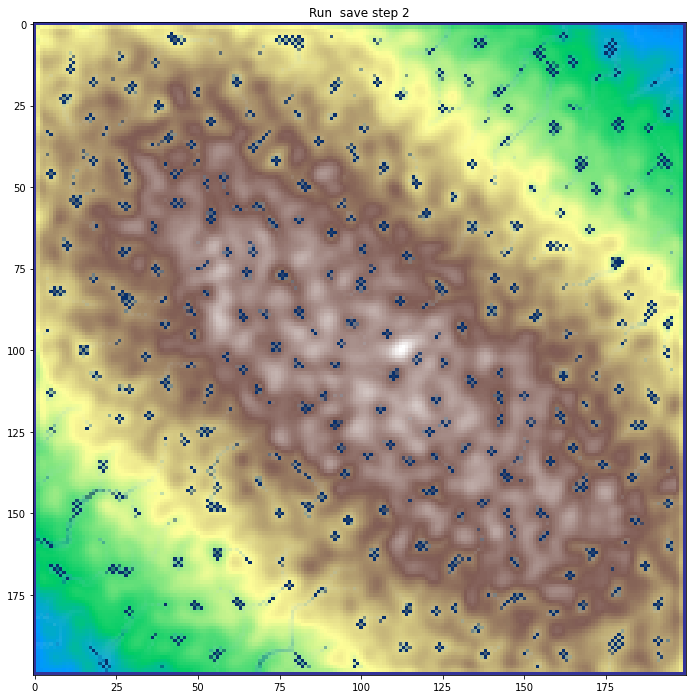

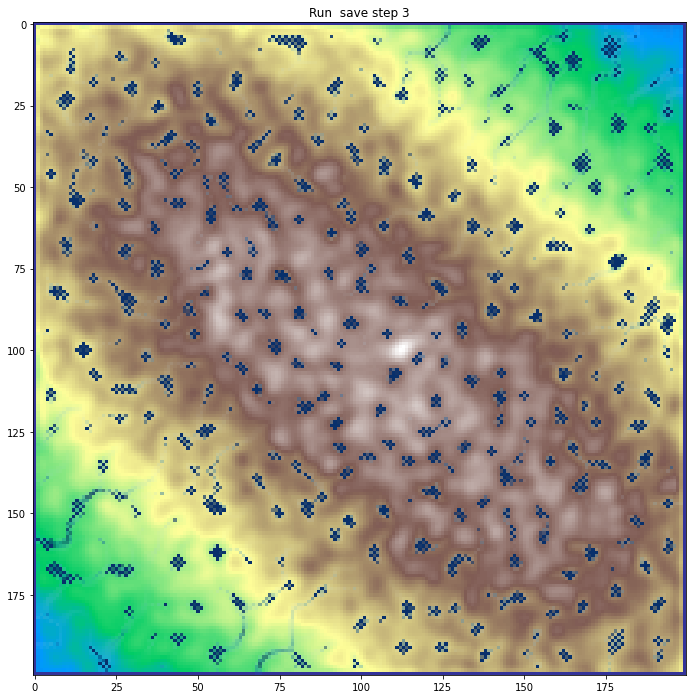

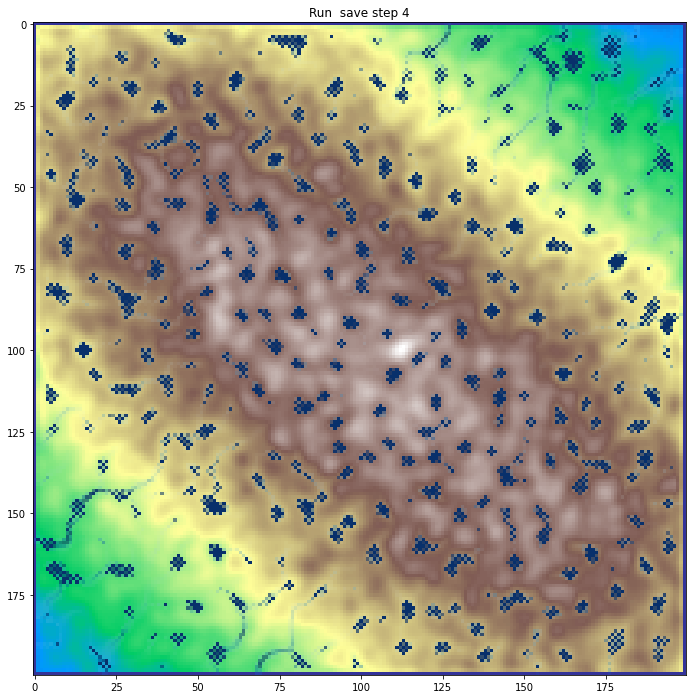

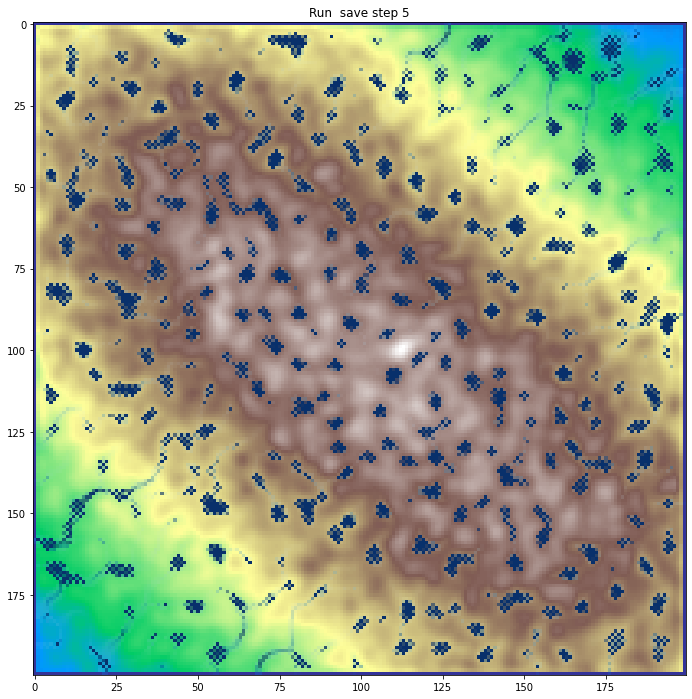

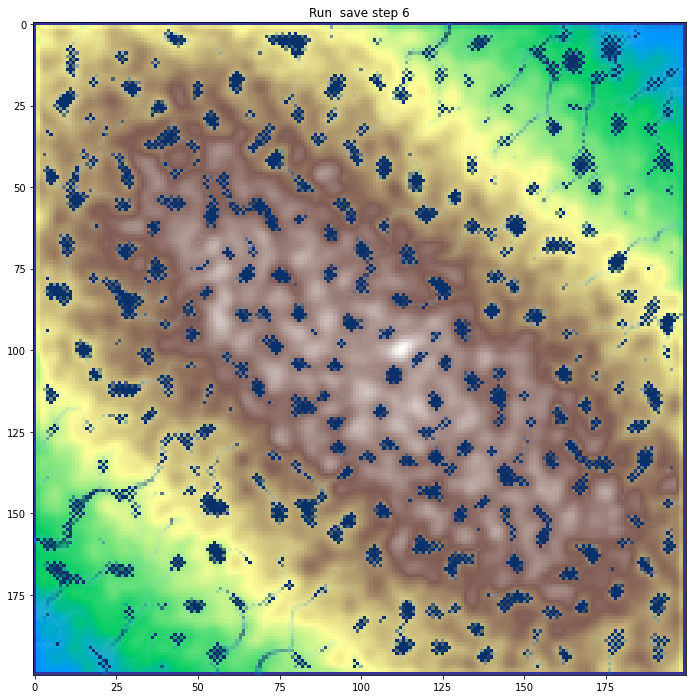

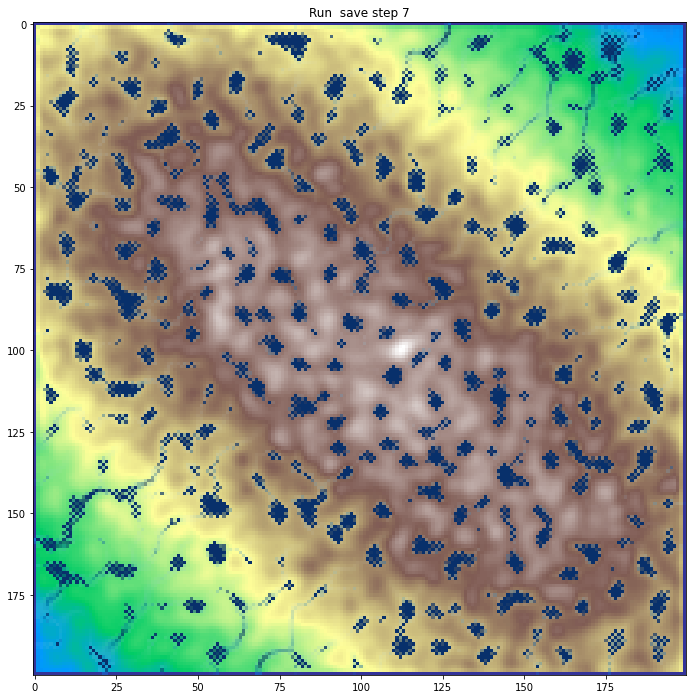

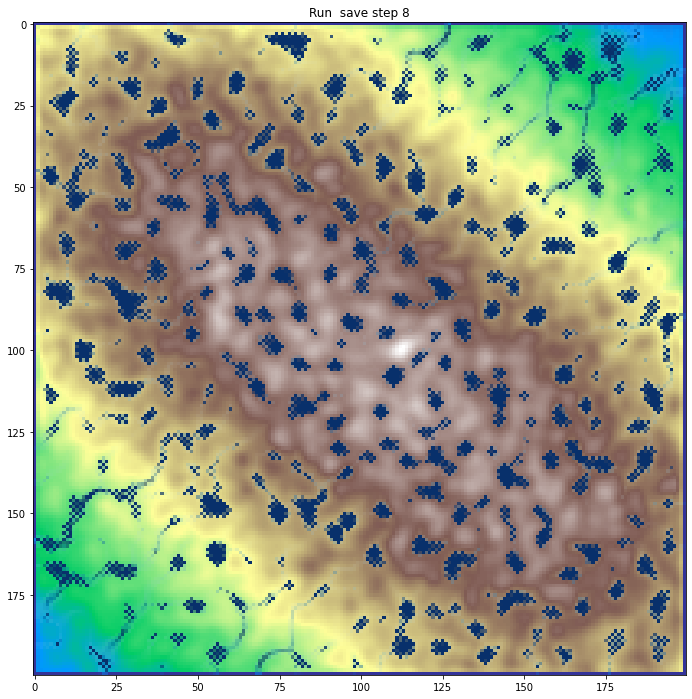

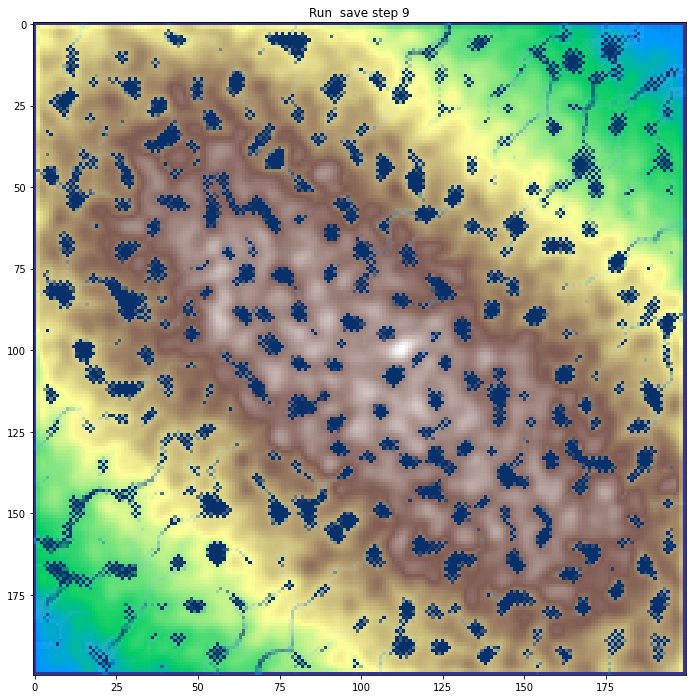

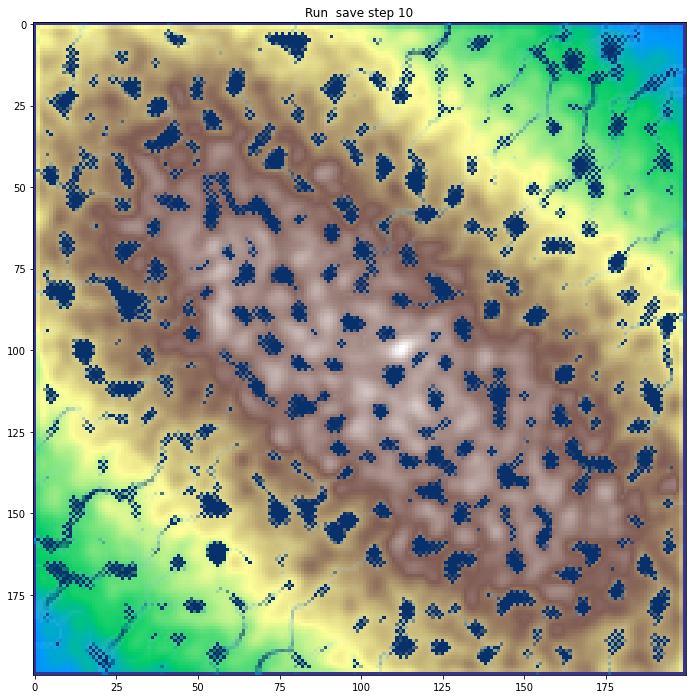

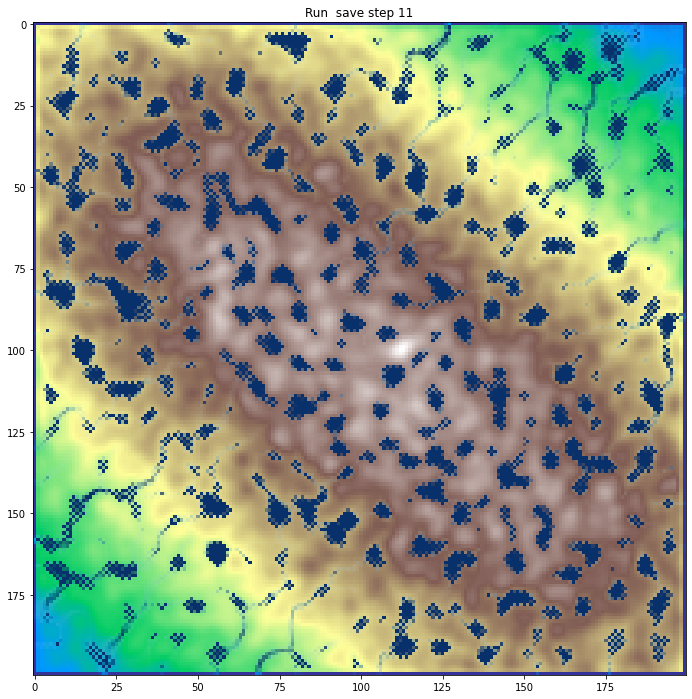

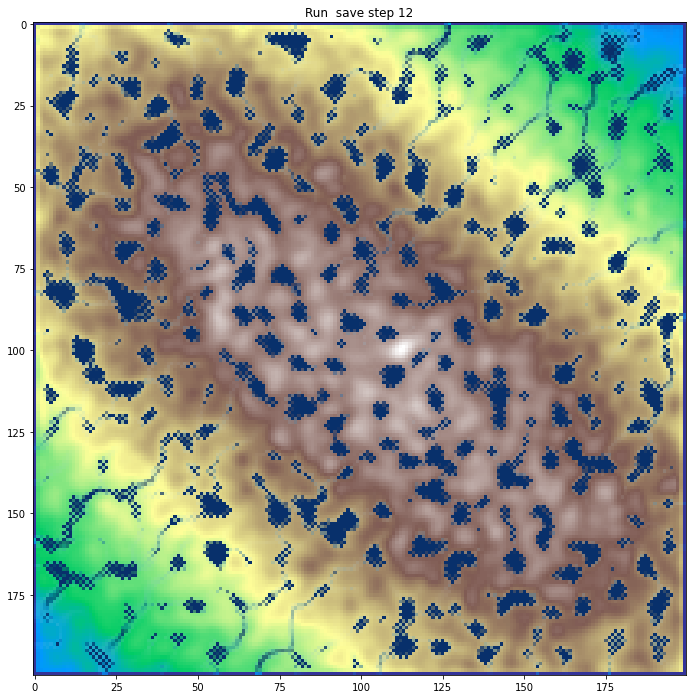

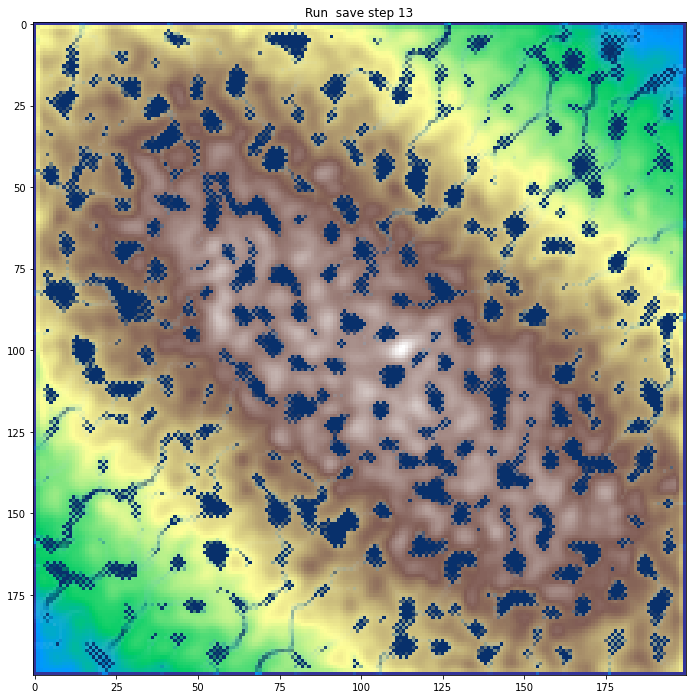

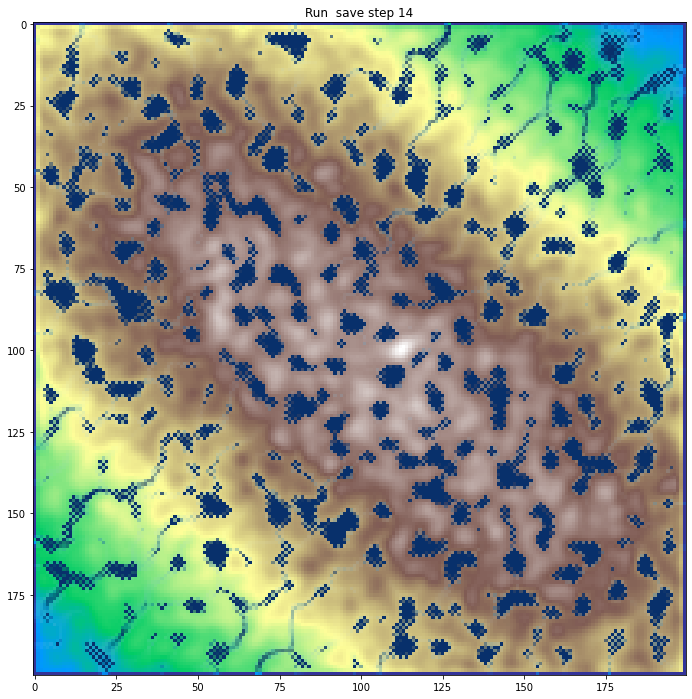

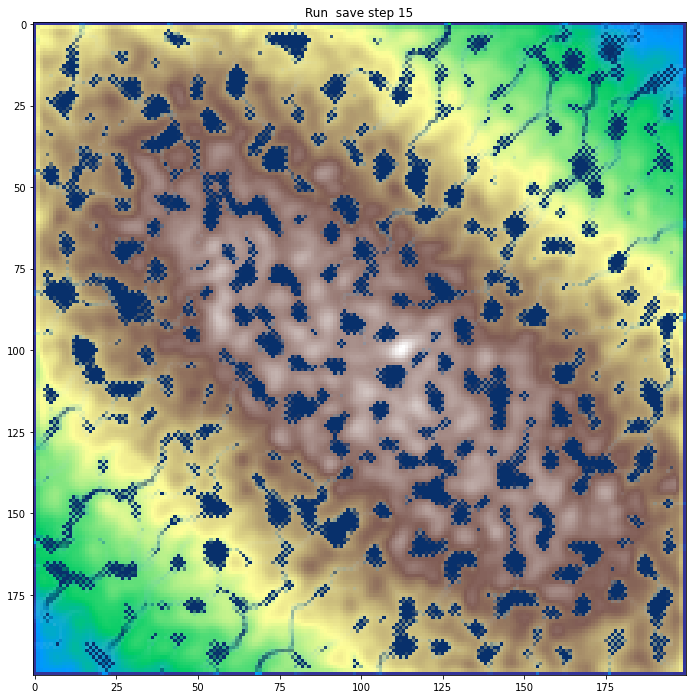

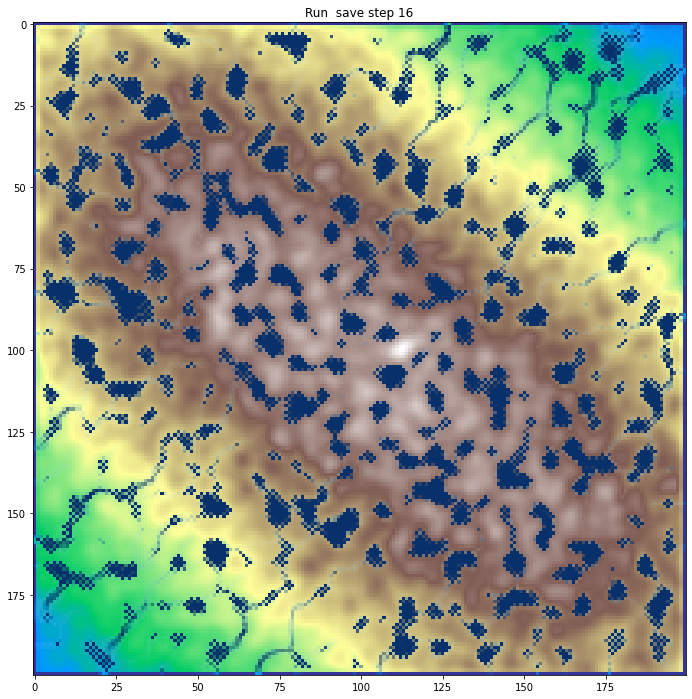

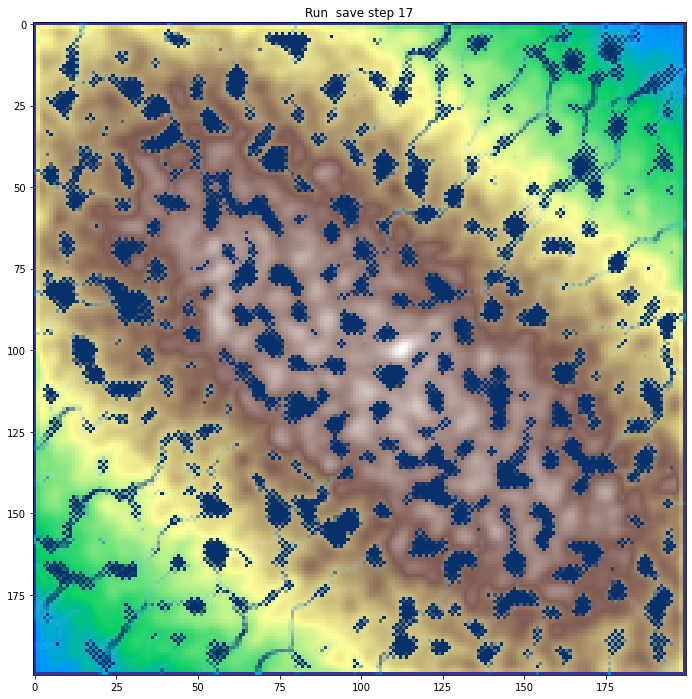

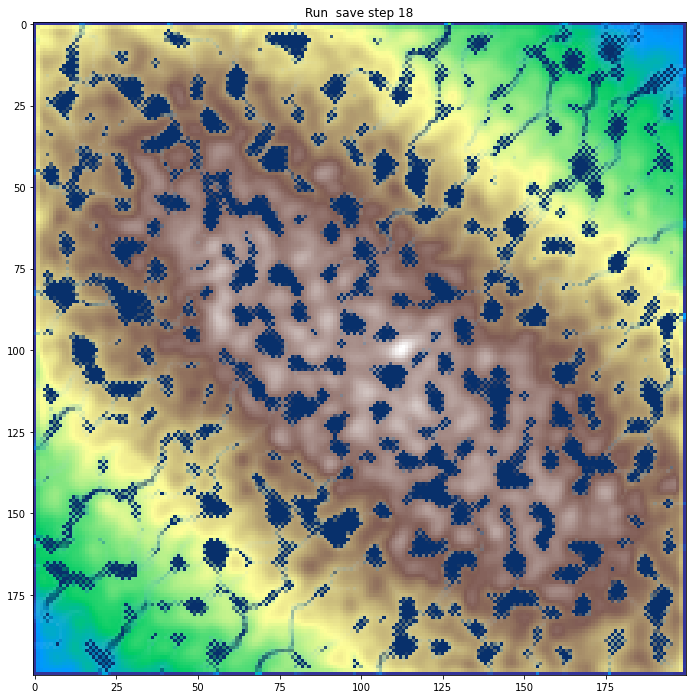

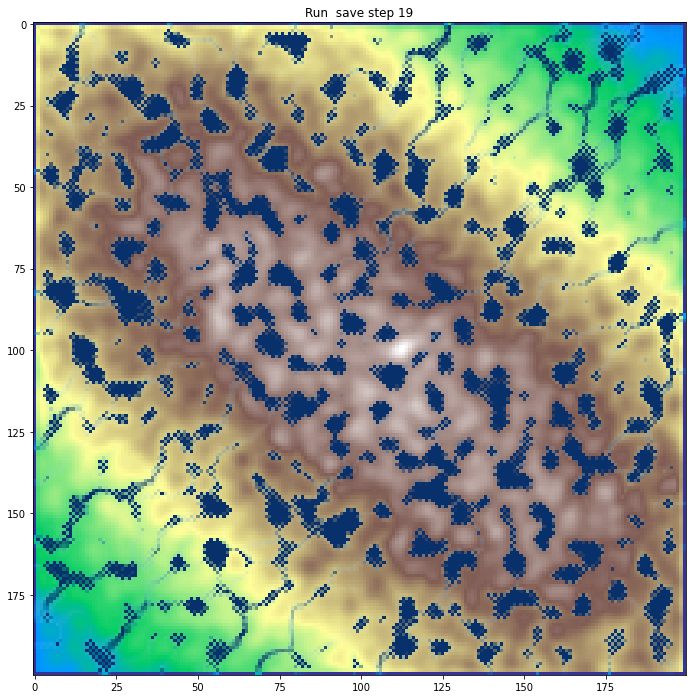

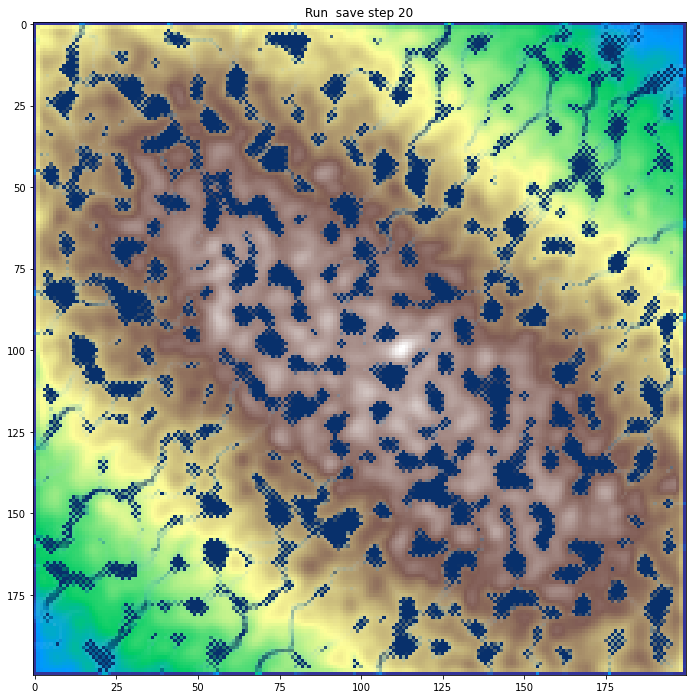

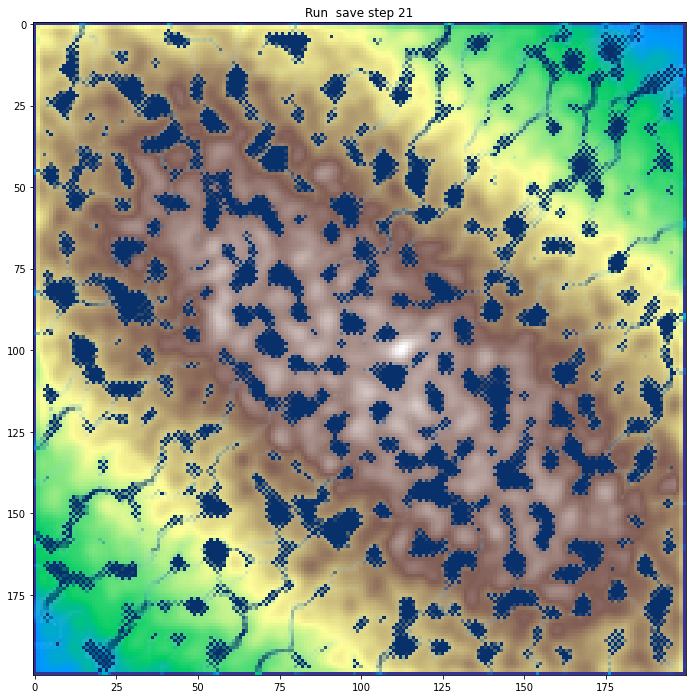

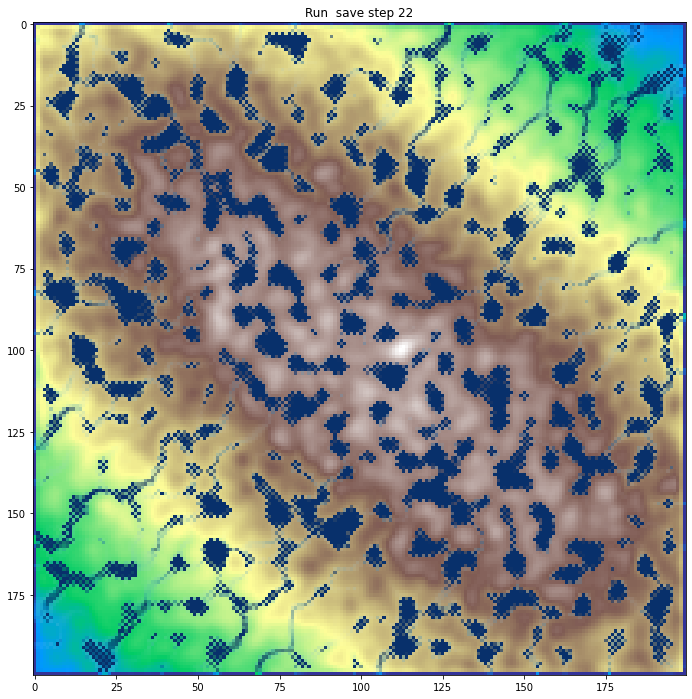

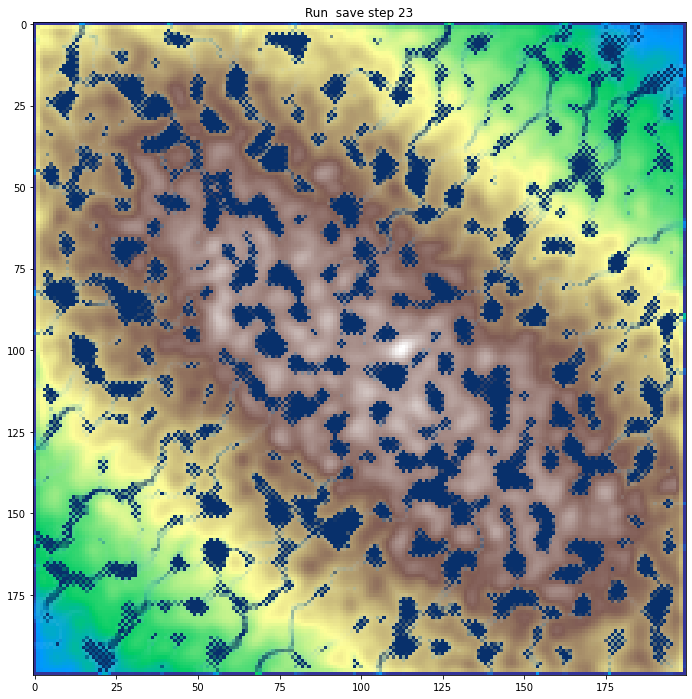

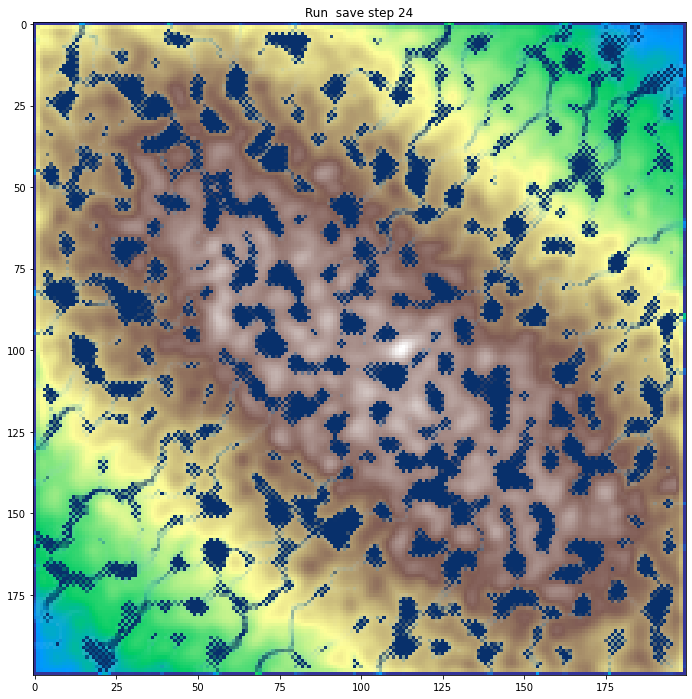

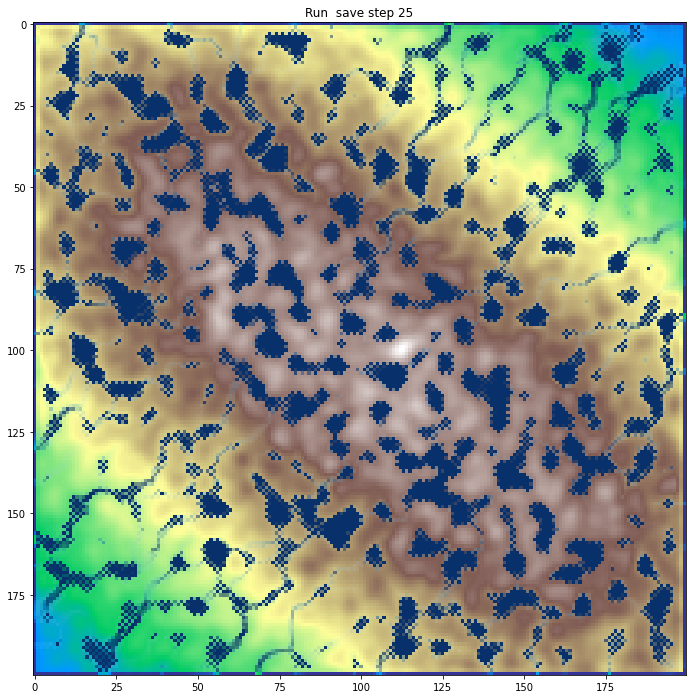

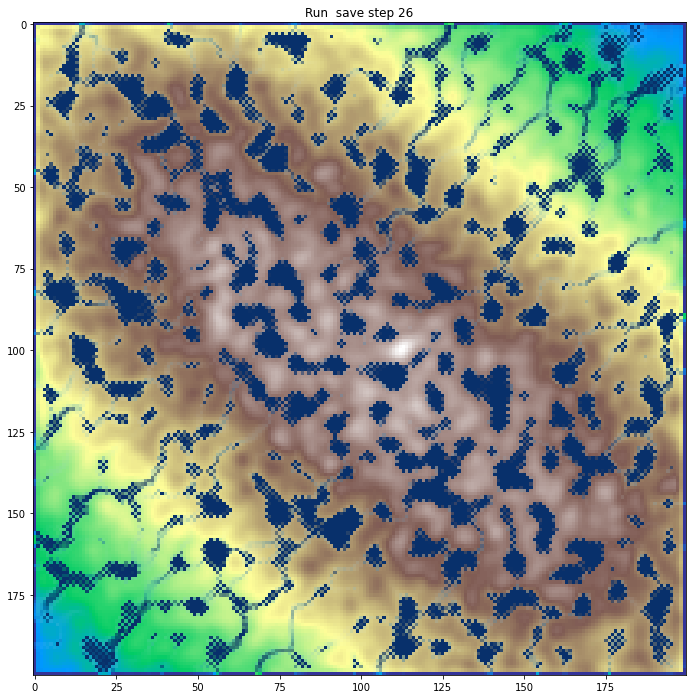

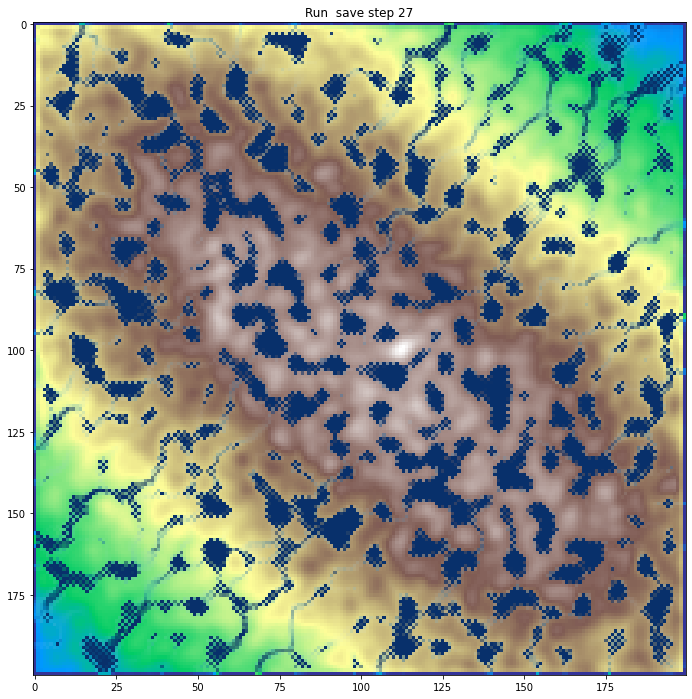

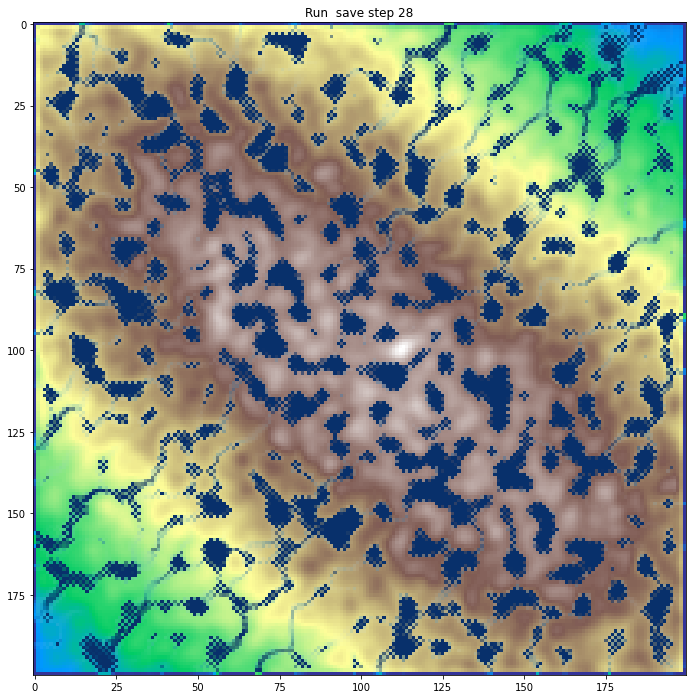

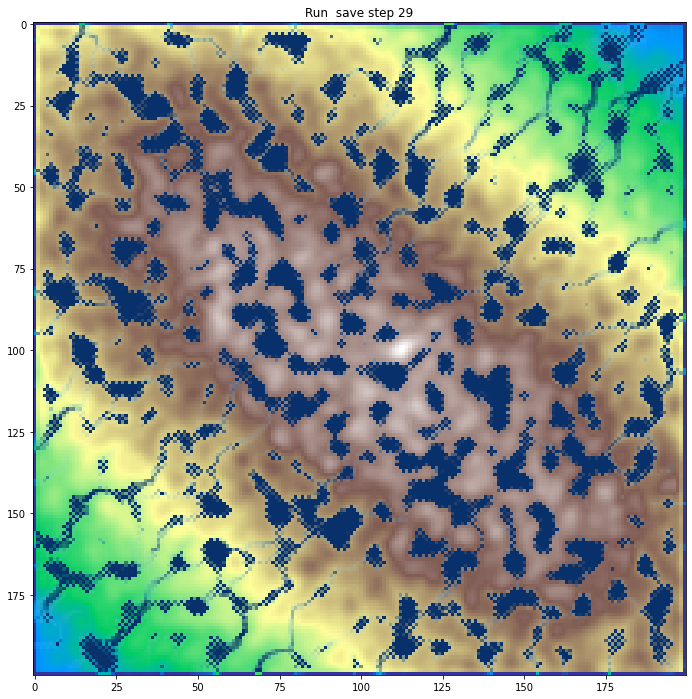

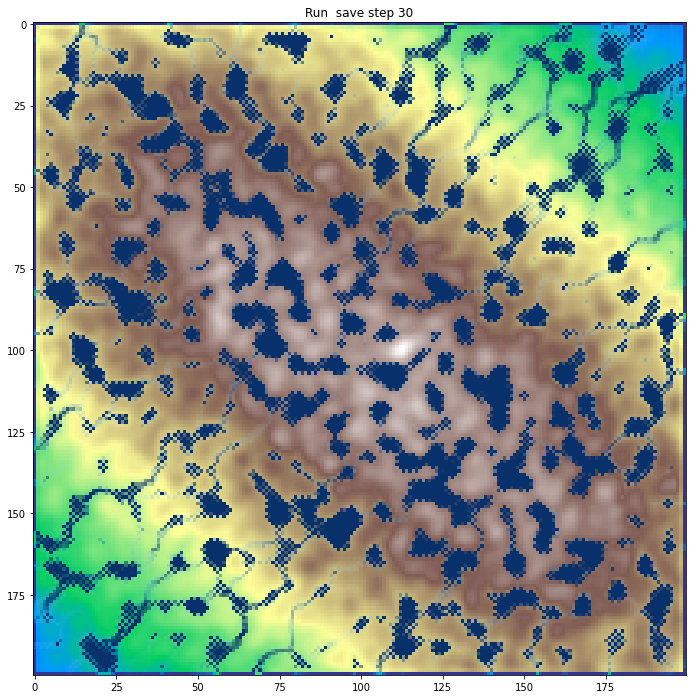

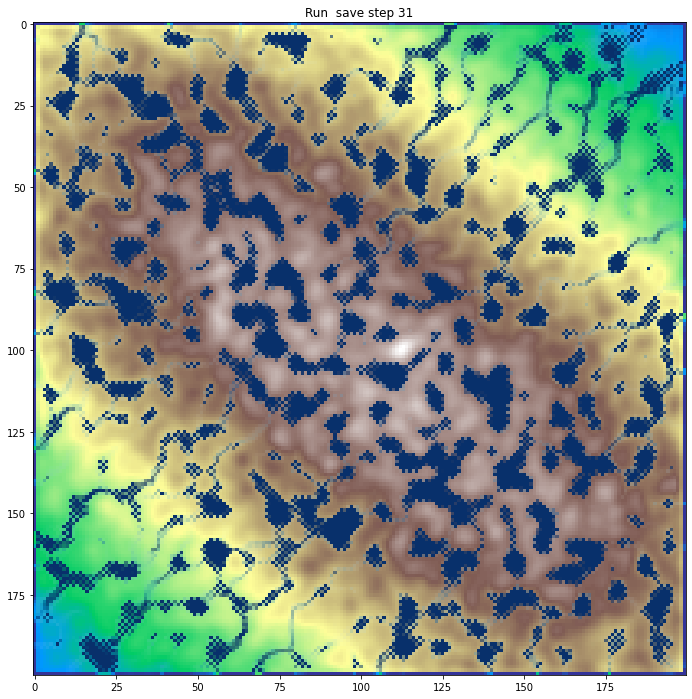

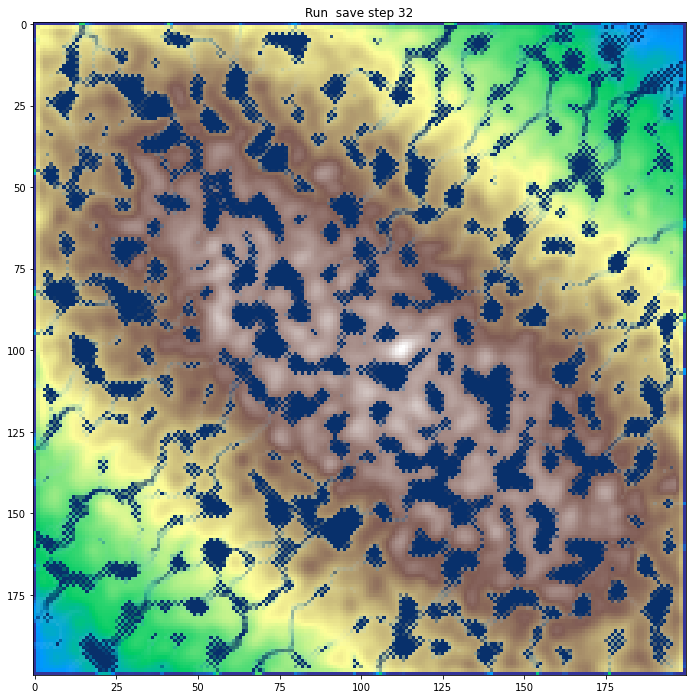

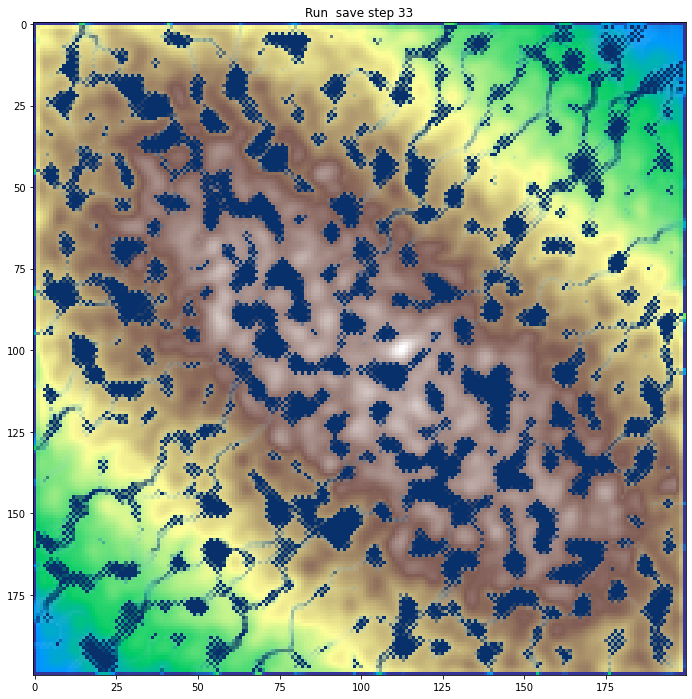

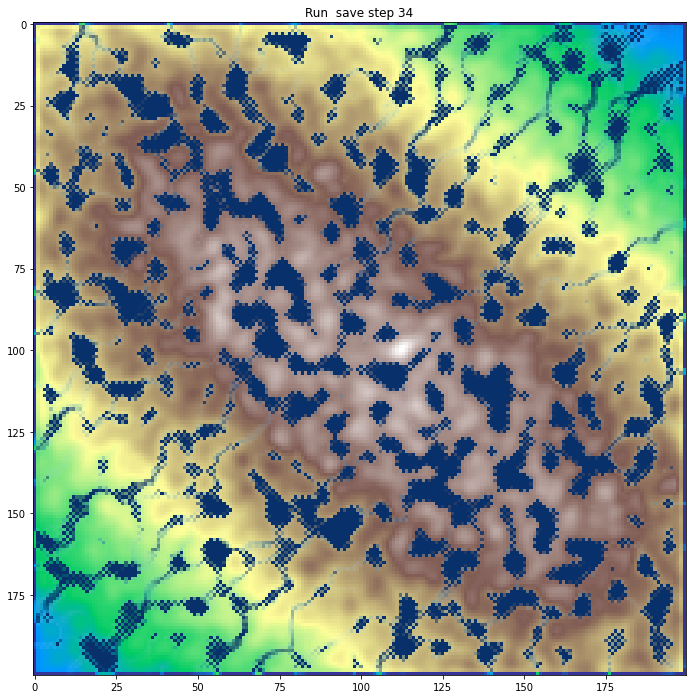

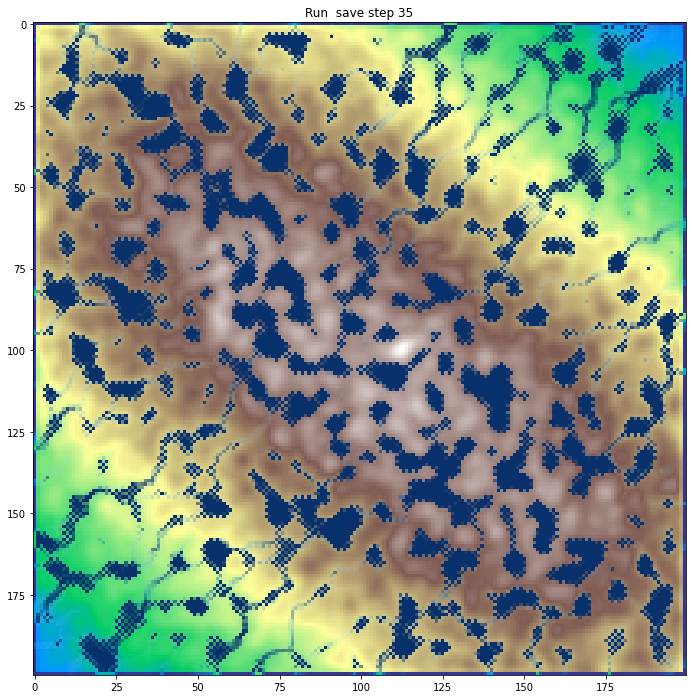

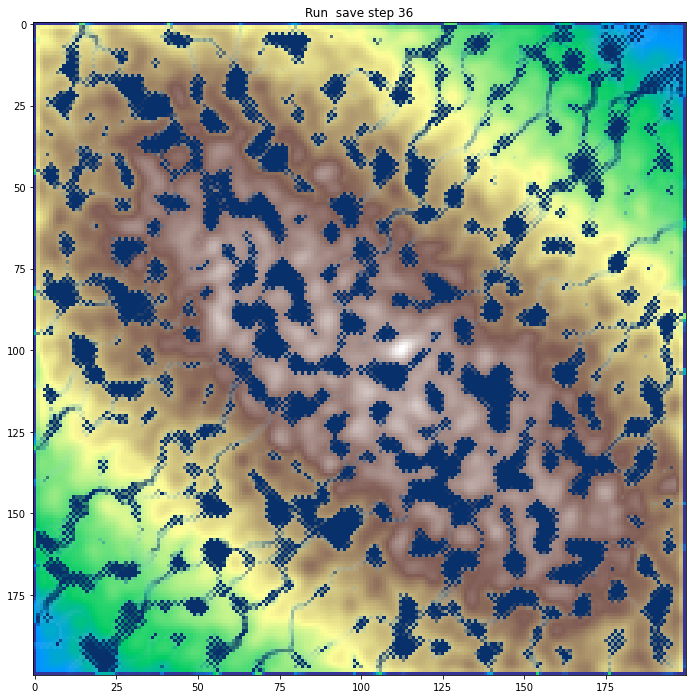

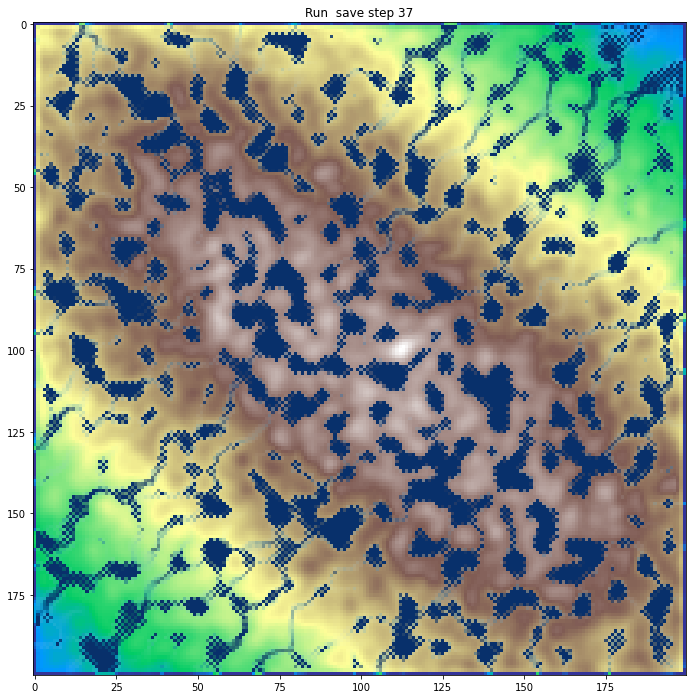

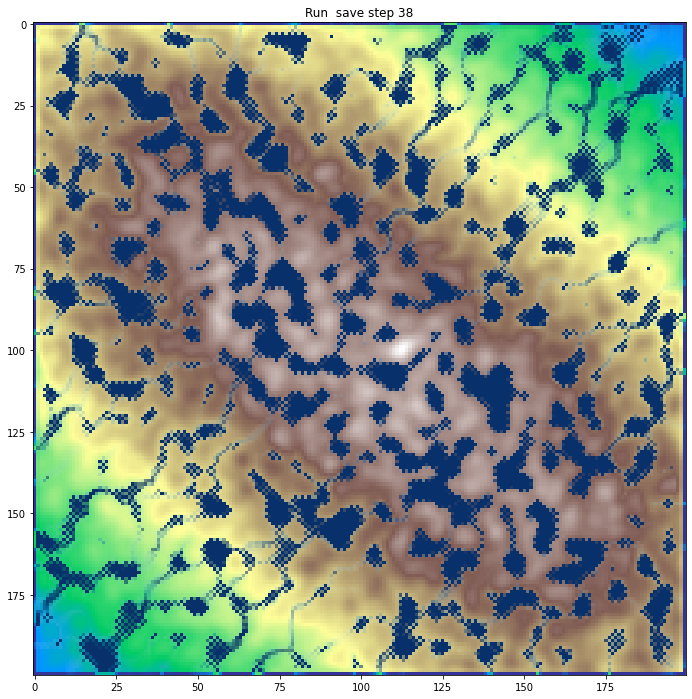

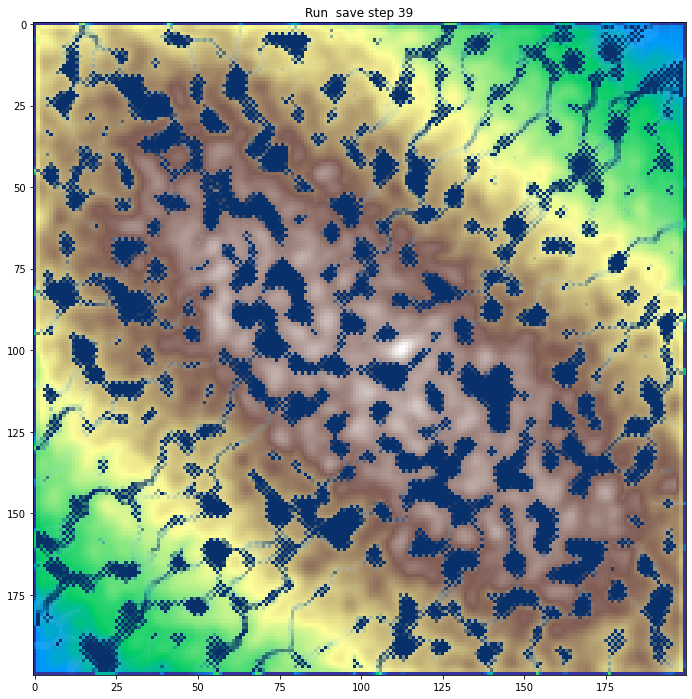

In [71]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i] + all_rock[i]
    ax.imshow(tmp, cmap=plt.cm.terrain, )

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

    alphas = all_waters[i] / 20
    alphas[alphas > 1] = 1
    ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)

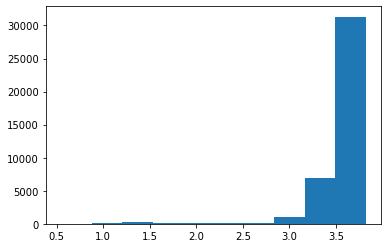

In [70]:
plt.hist(np.log10(tmp.flatten()))
None

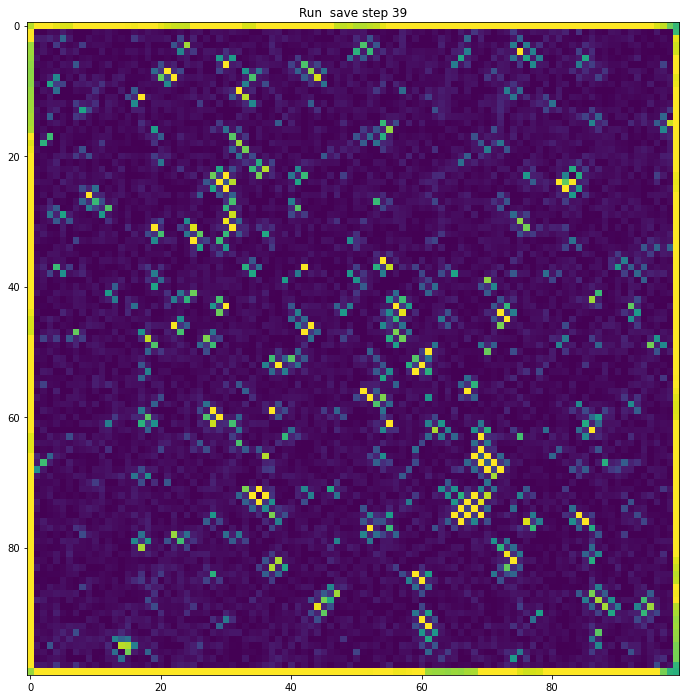

In [33]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
title = "Run  save step " + str(i)
ax.set_title(title)    
tmp1 = ((all_gravel[-1] + all_rock[-1]) + (all_gravel[-2] + all_rock[-2])) / 2. 
tmp = tmp1 - (all_gravel[0] + all_rock[0])
ax.imshow(tmp, vmin=-20, vmax=20)

/tmp/ipykernel_5482/665856109.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


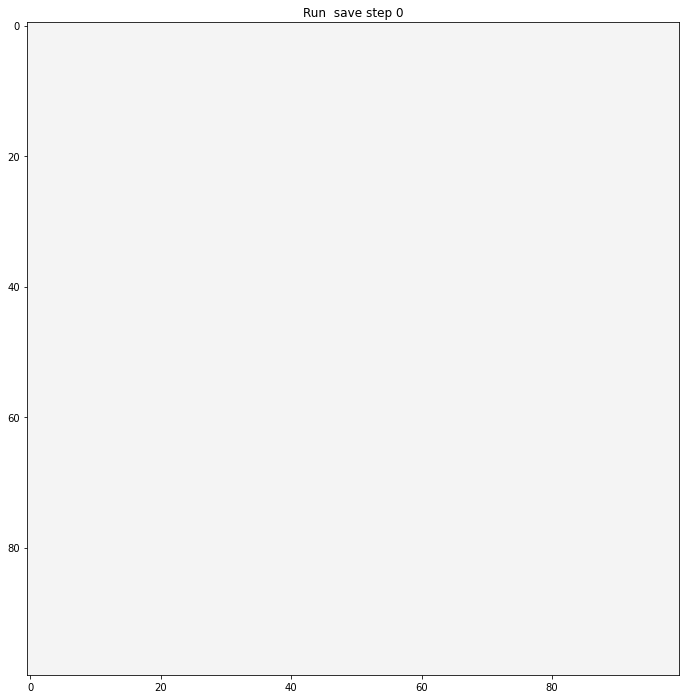

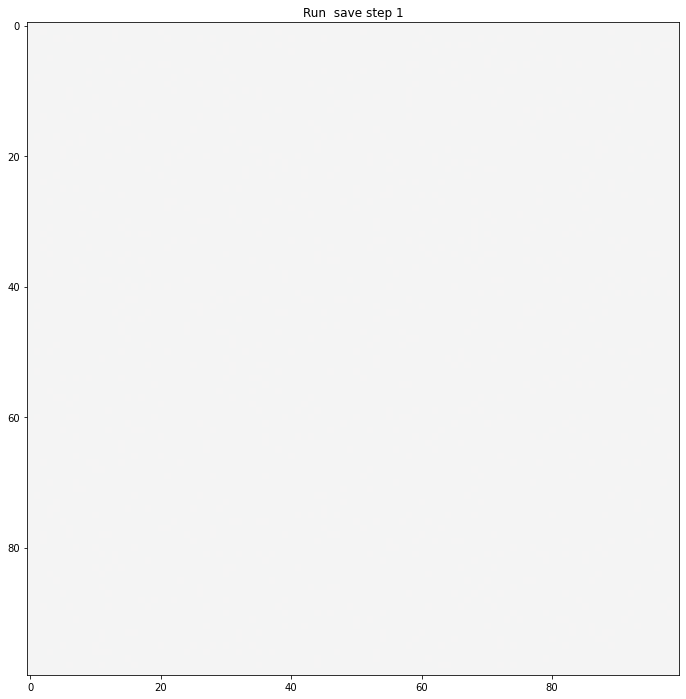

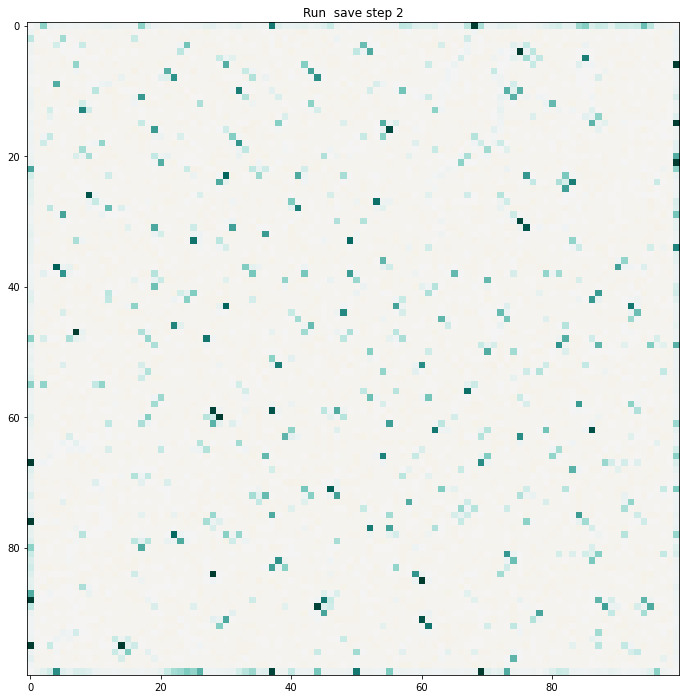

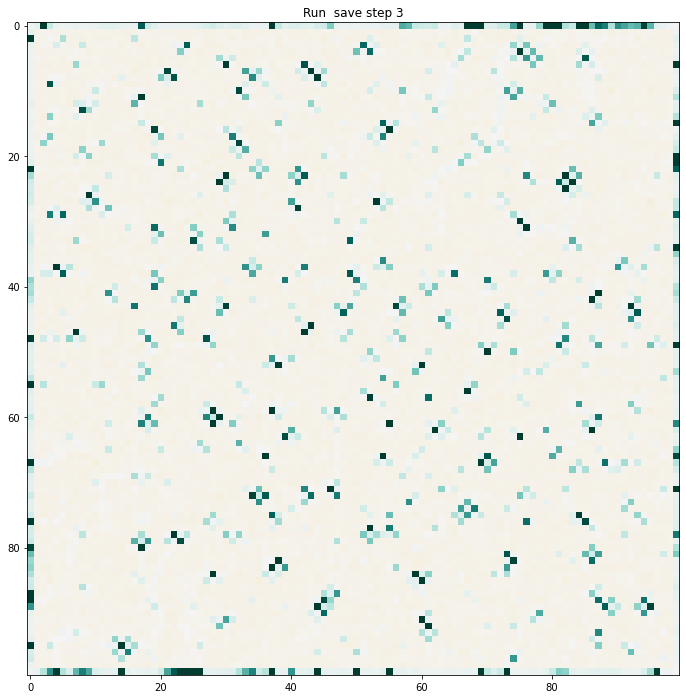

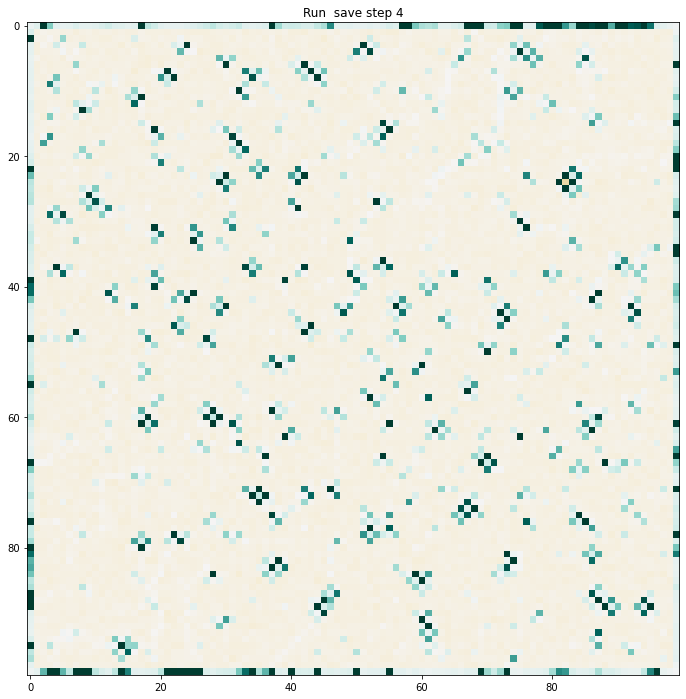

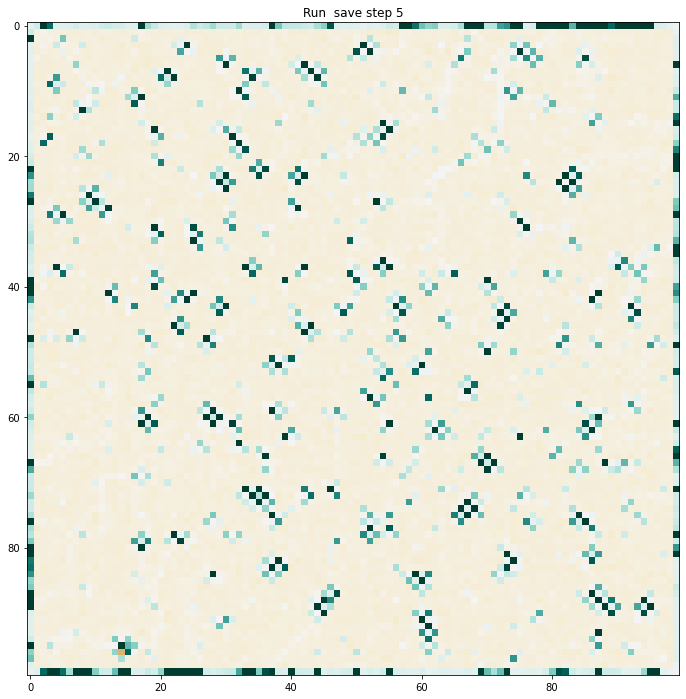

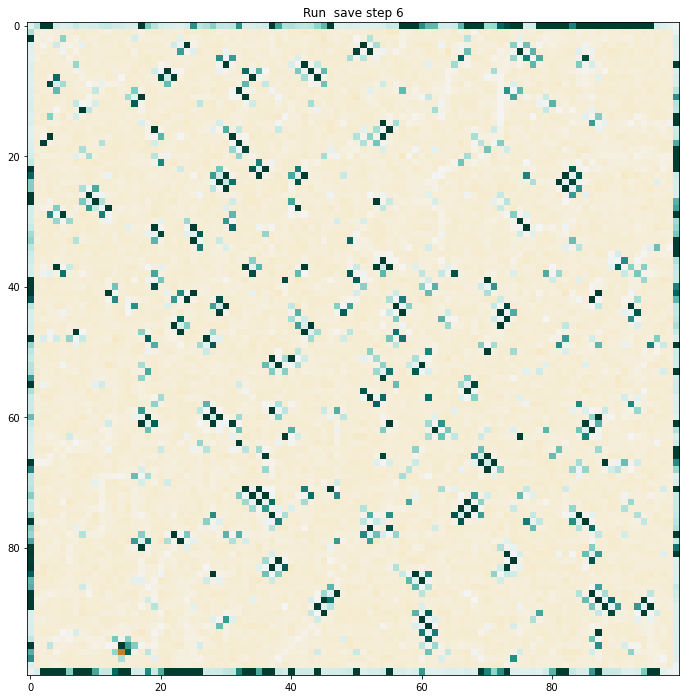

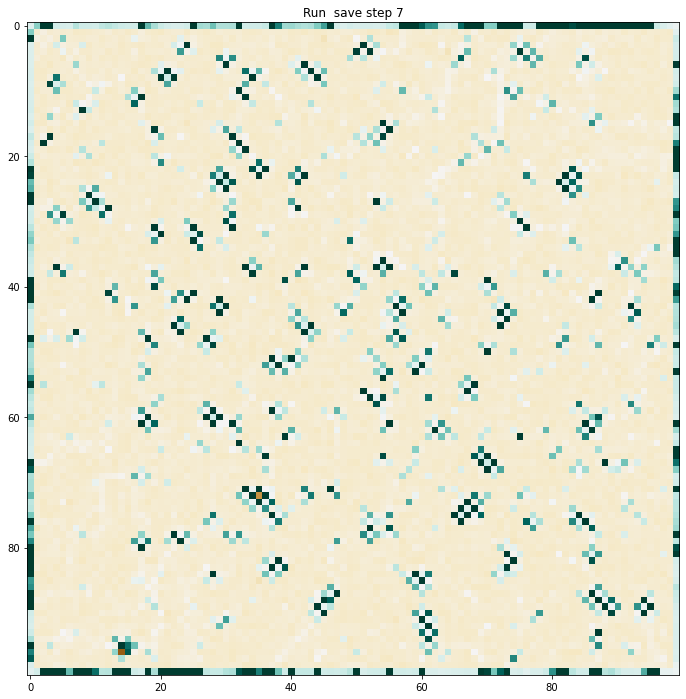

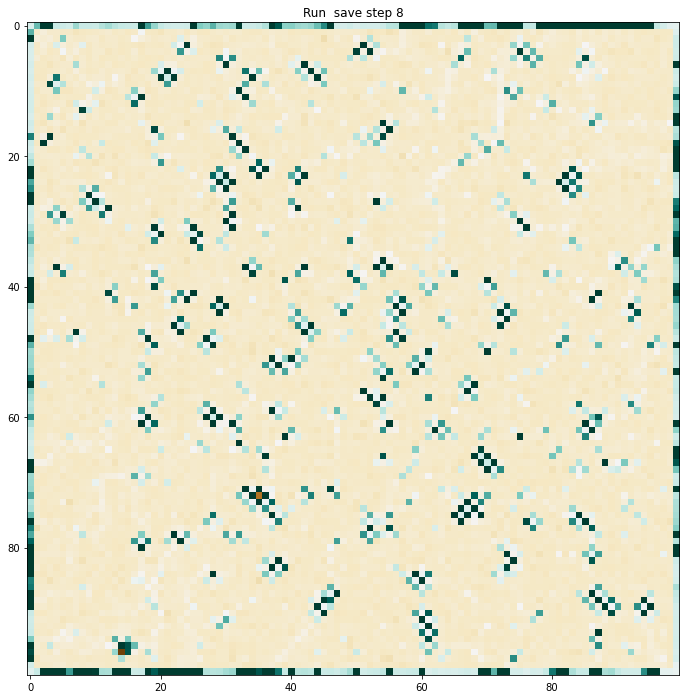

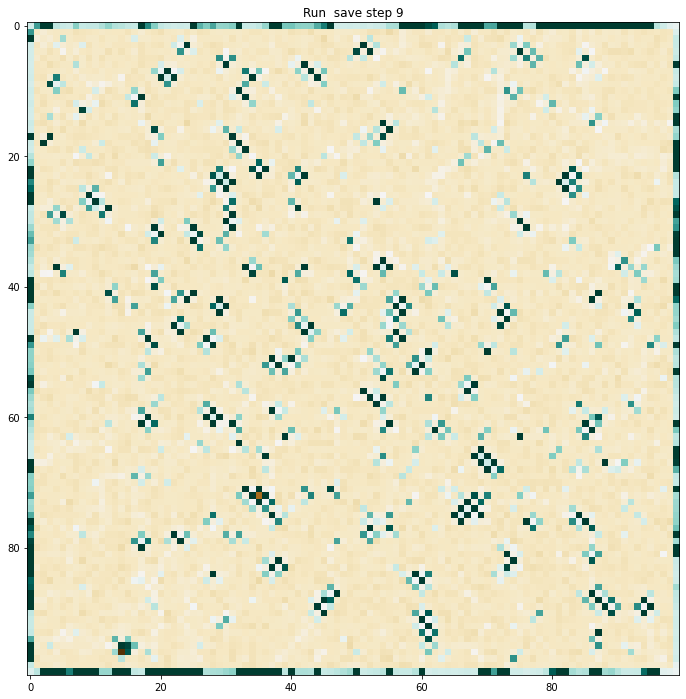

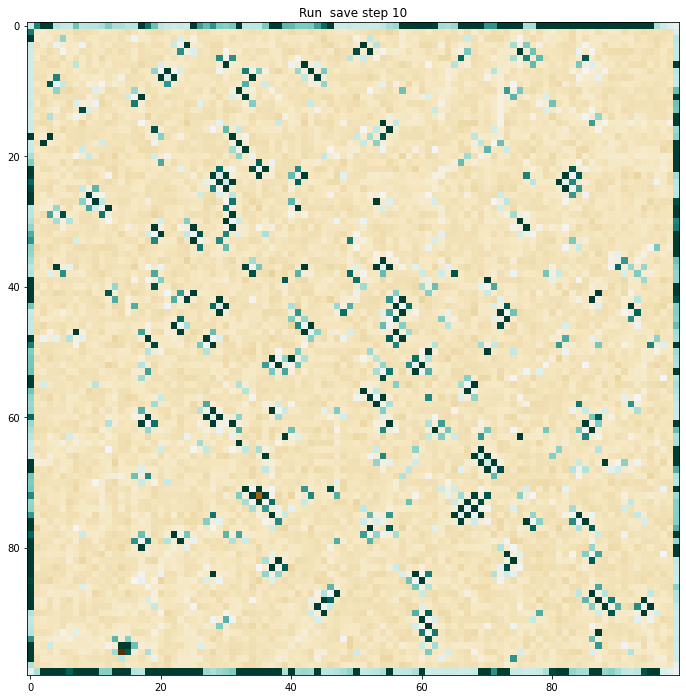

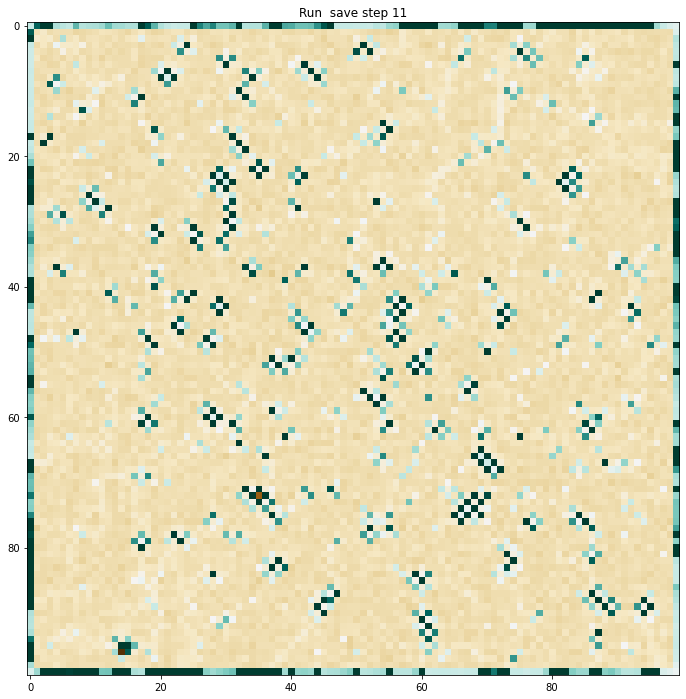

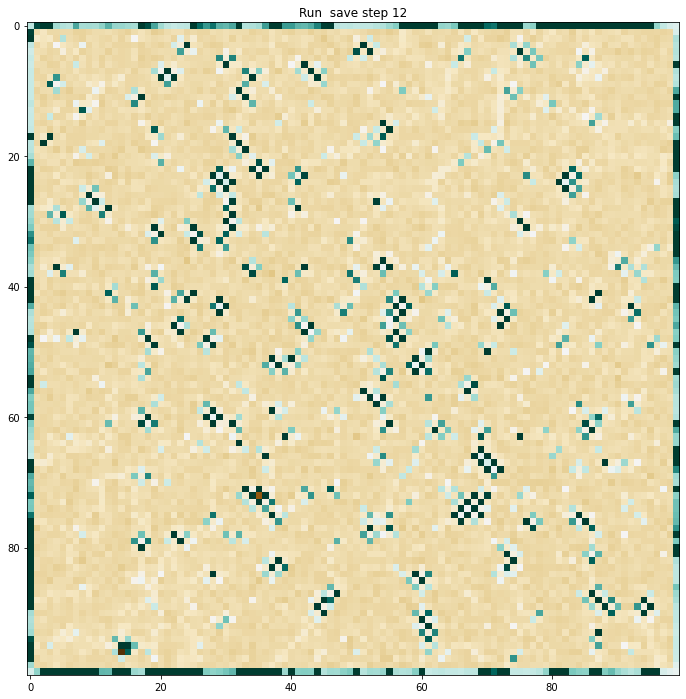

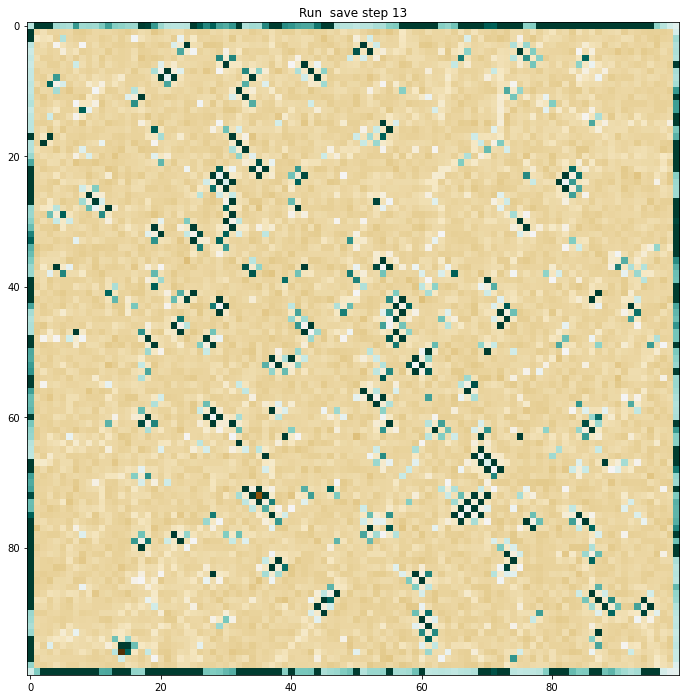

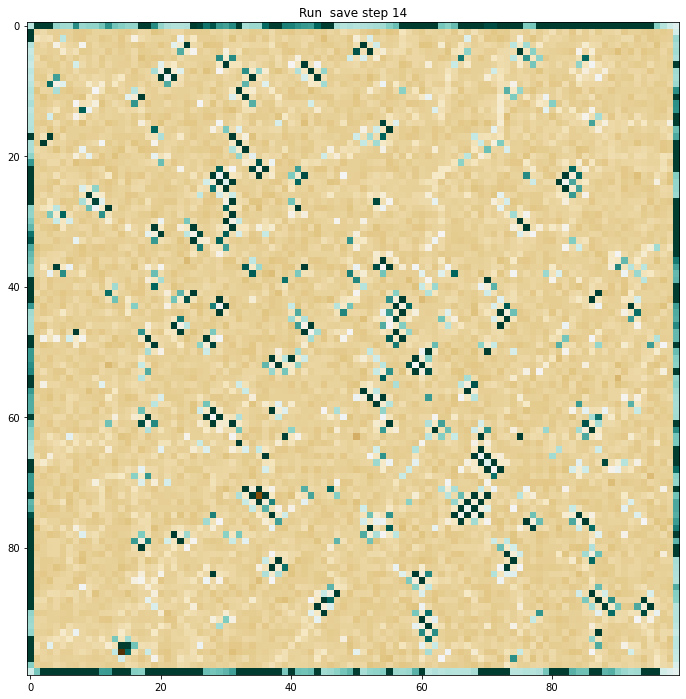

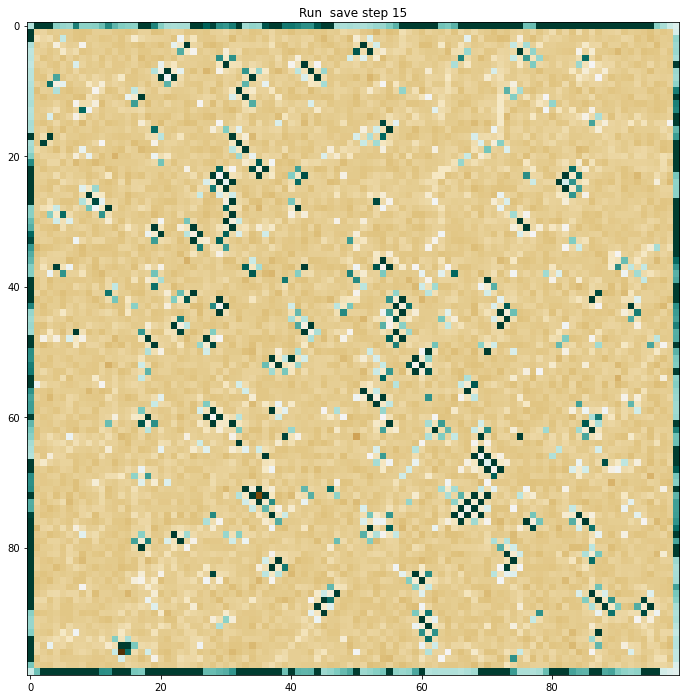

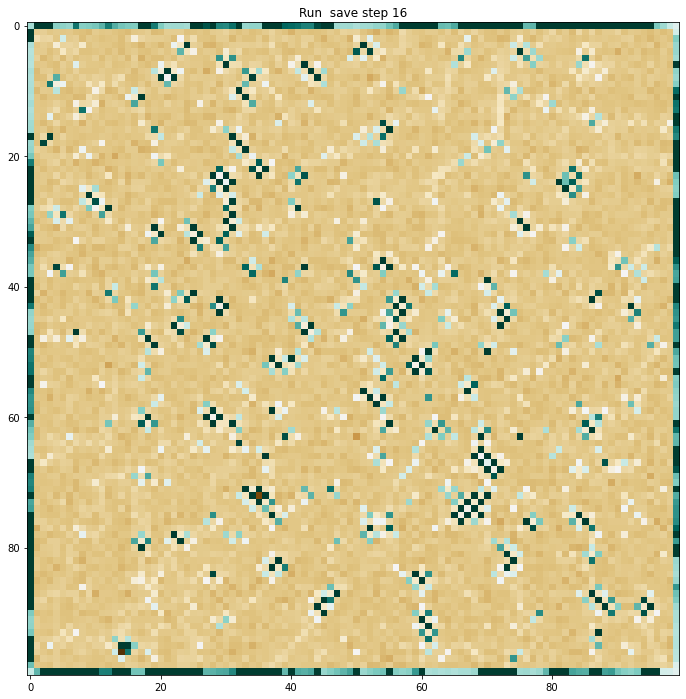

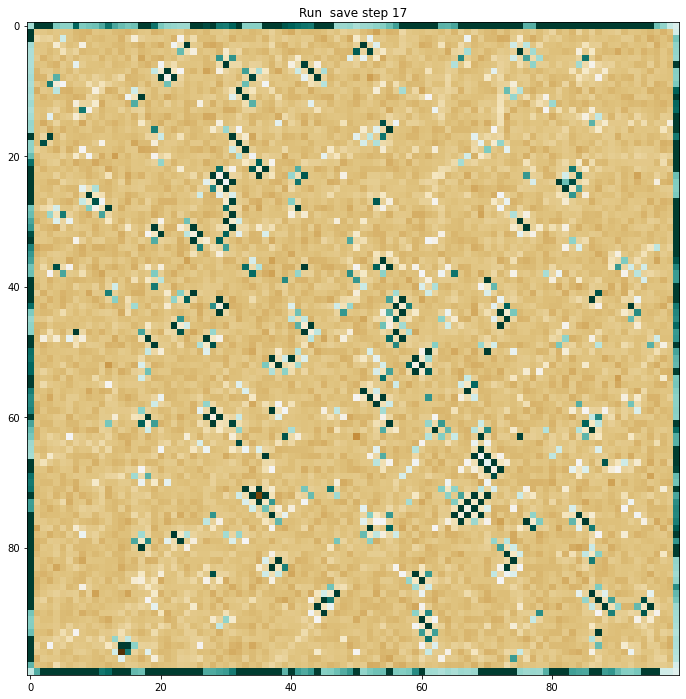

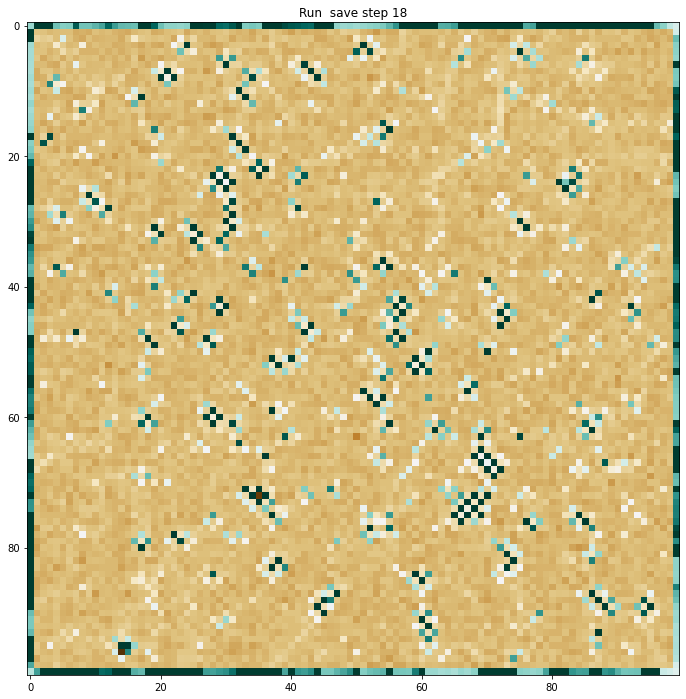

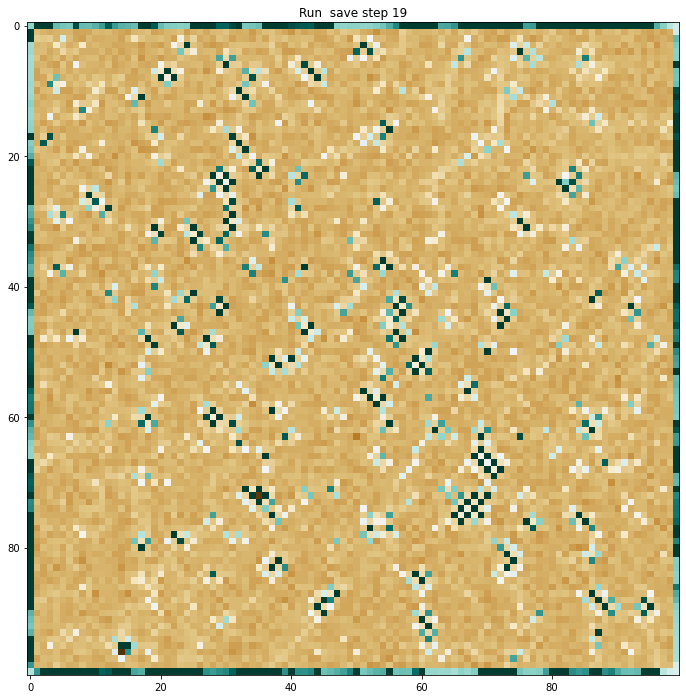

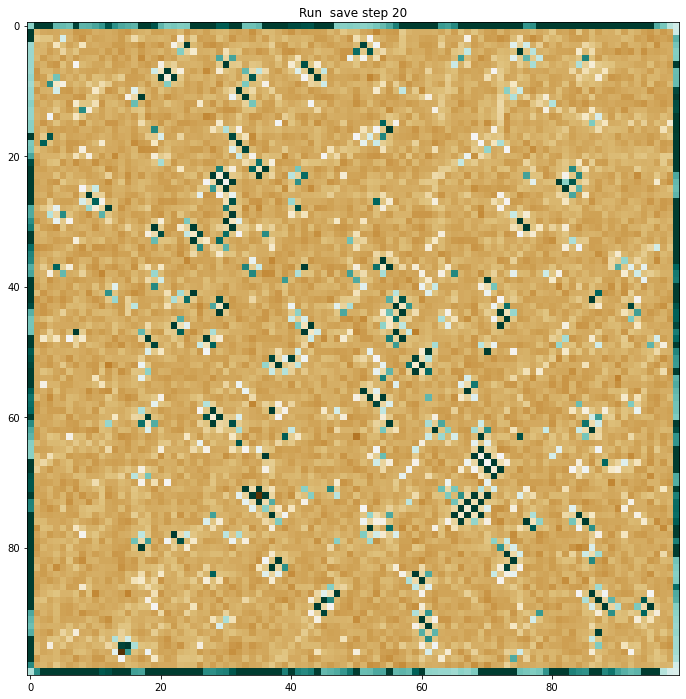

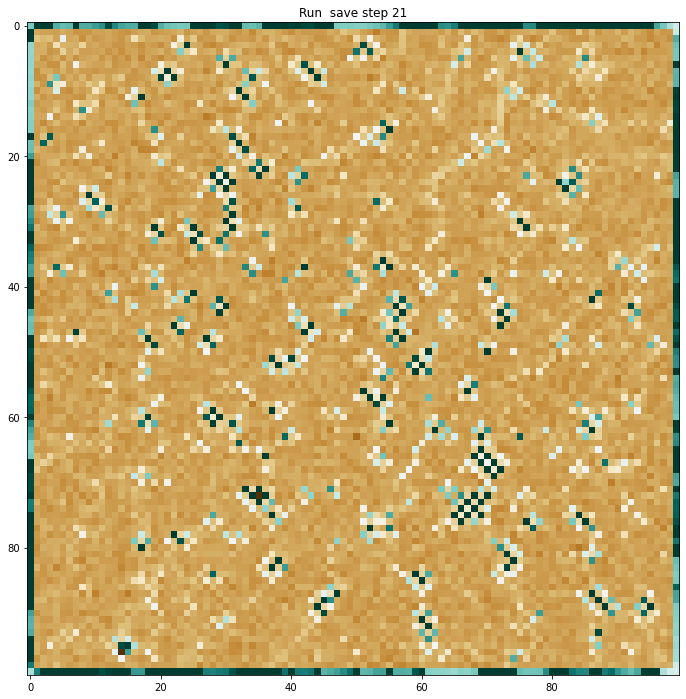

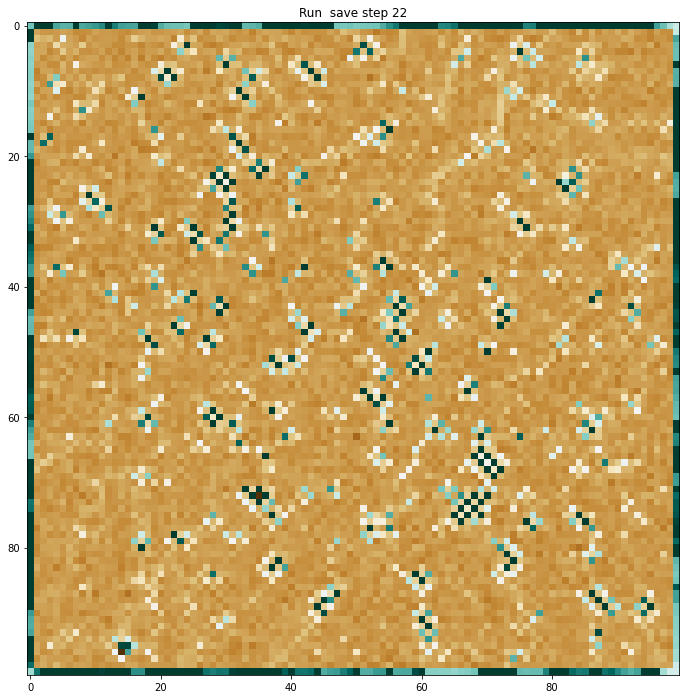

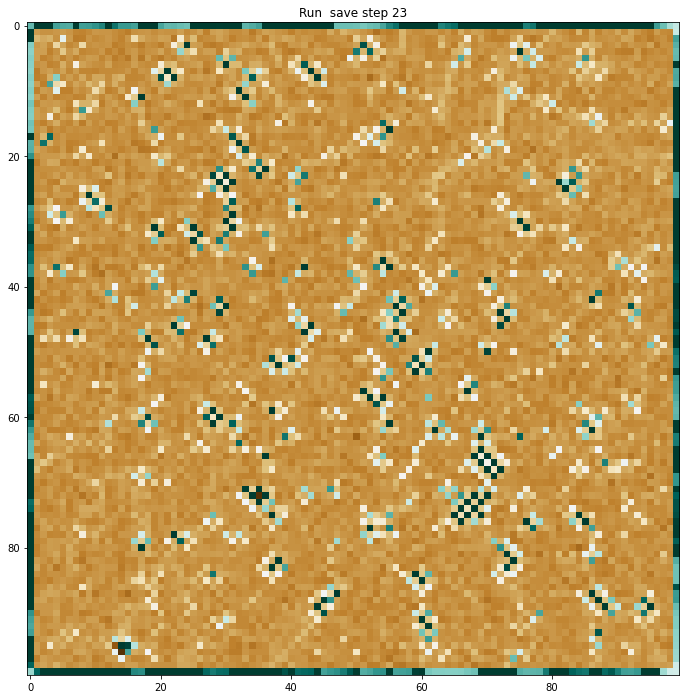

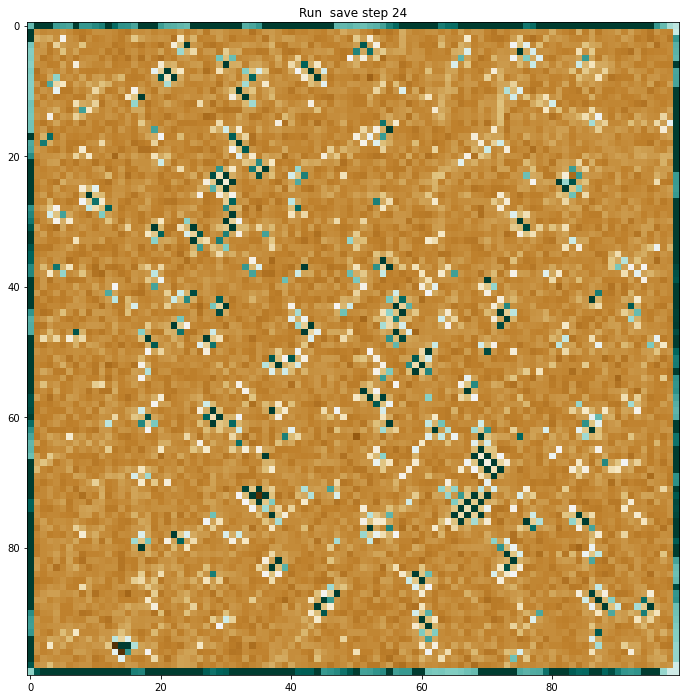

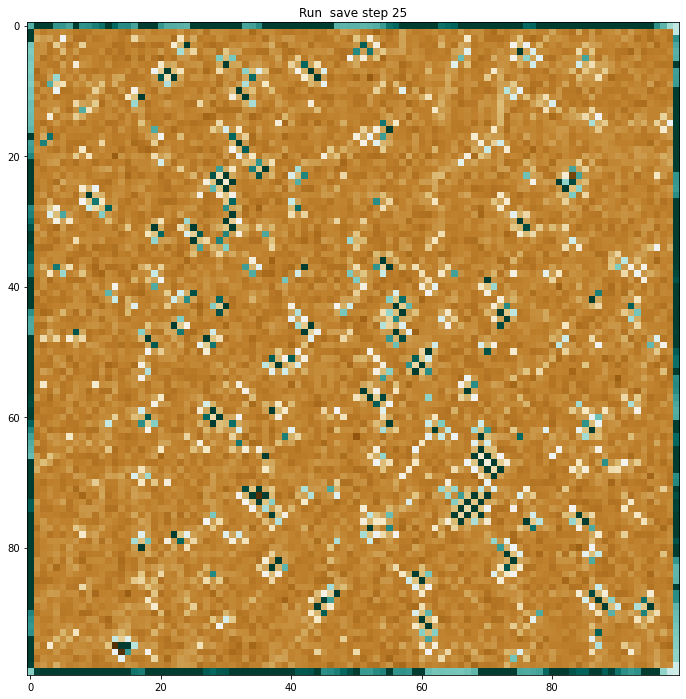

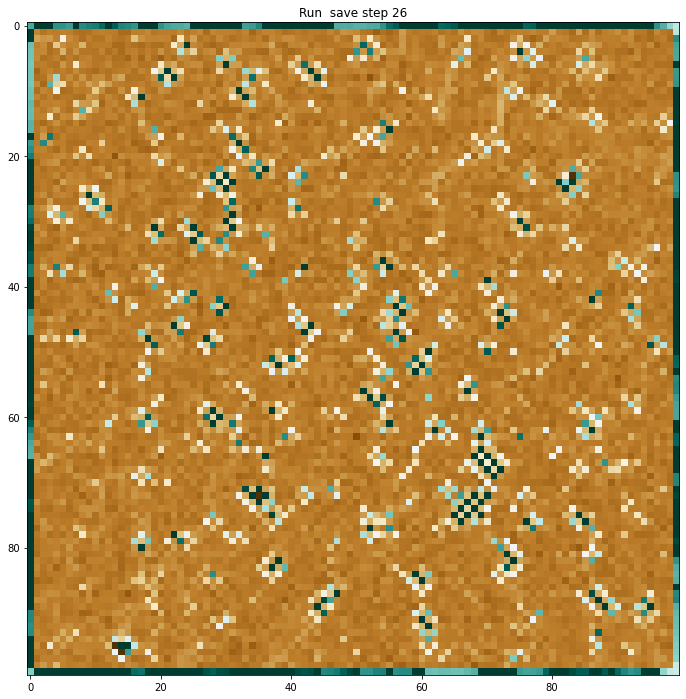

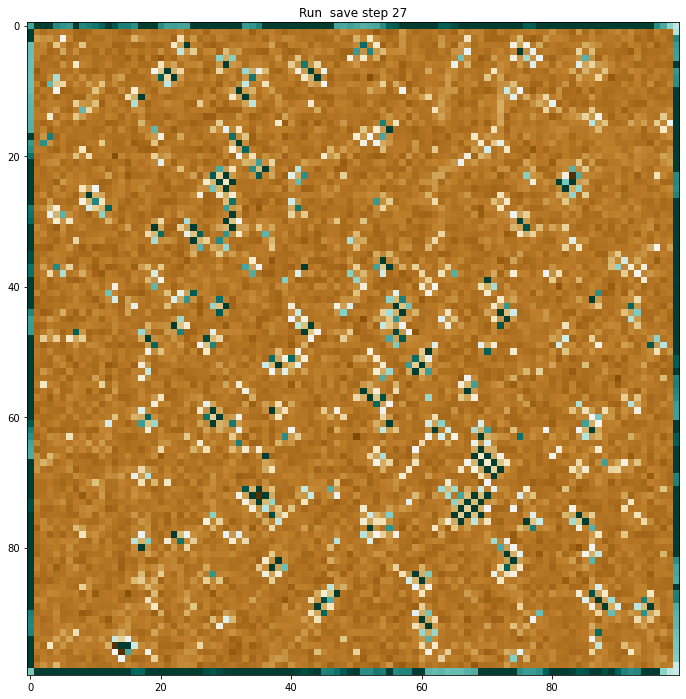

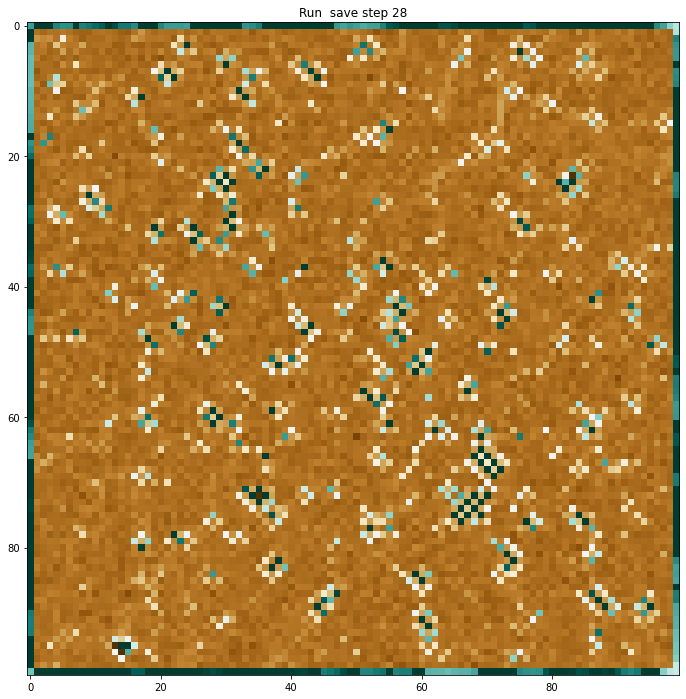

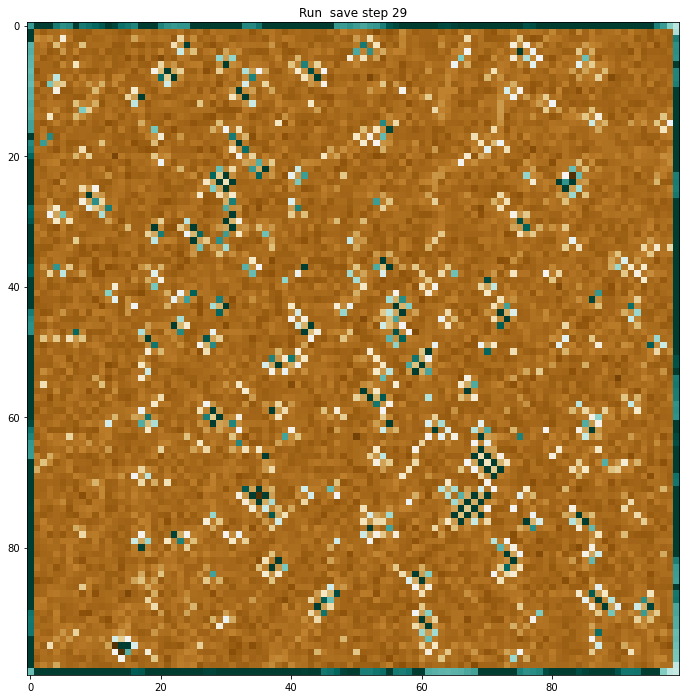

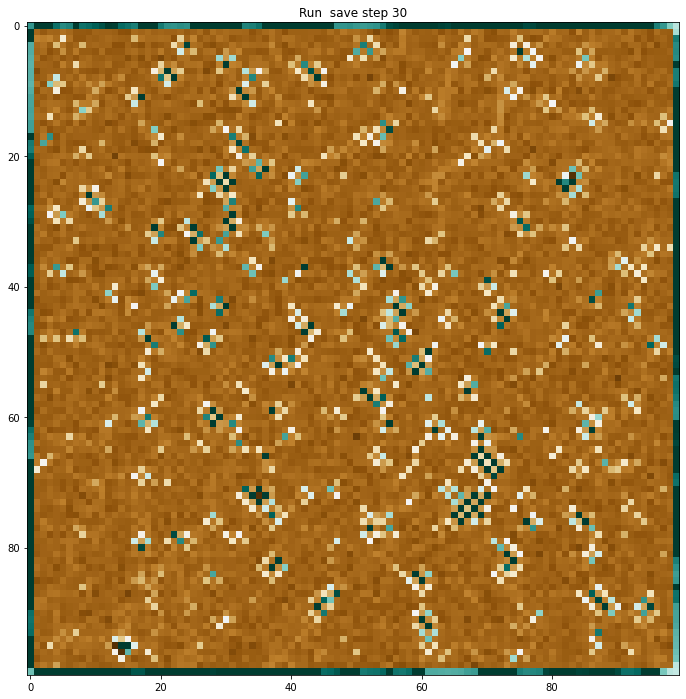

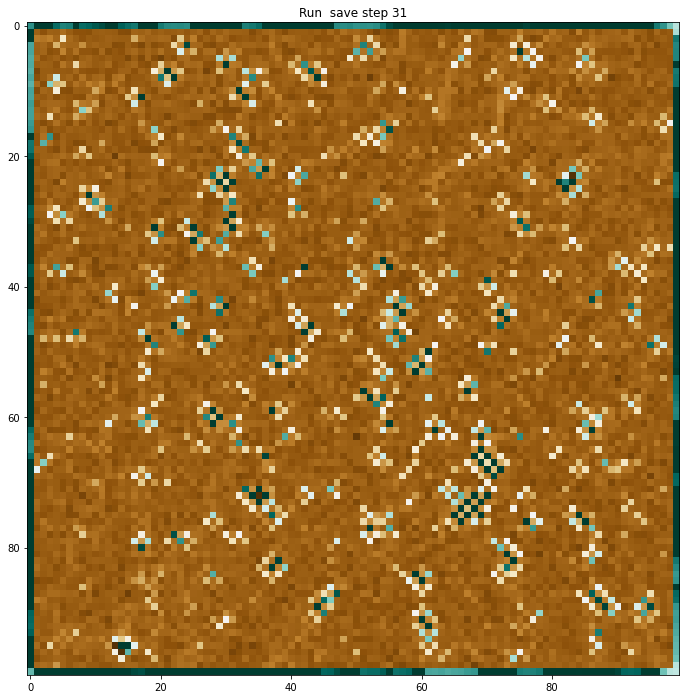

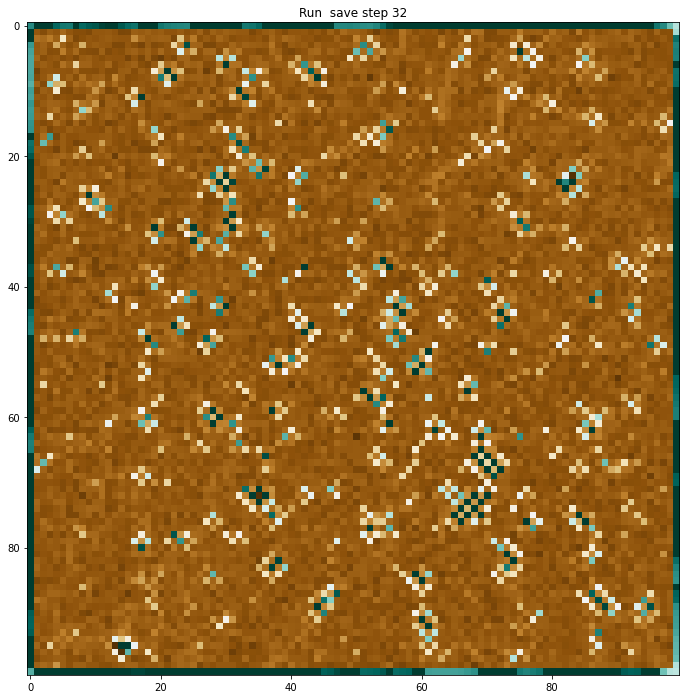

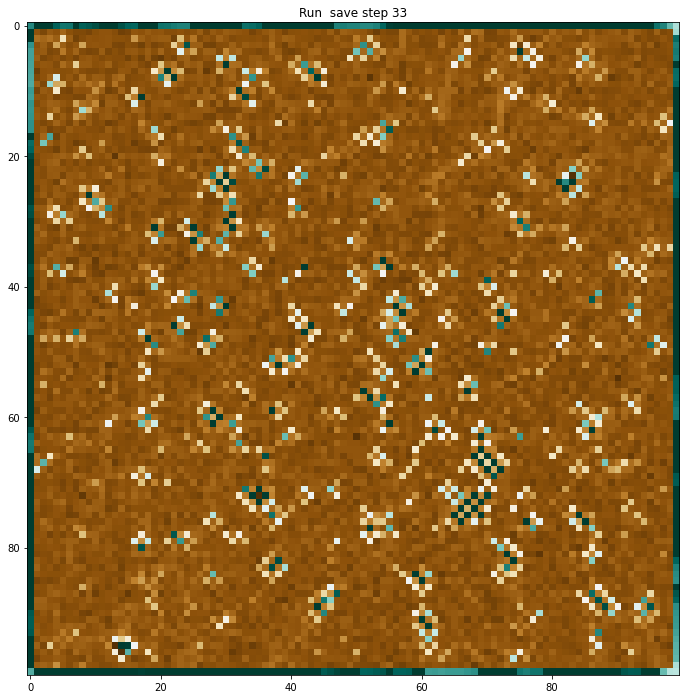

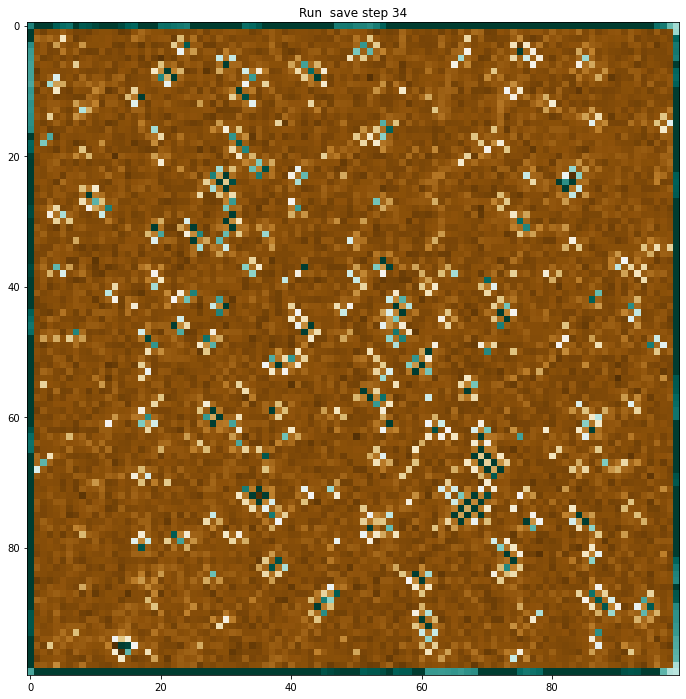

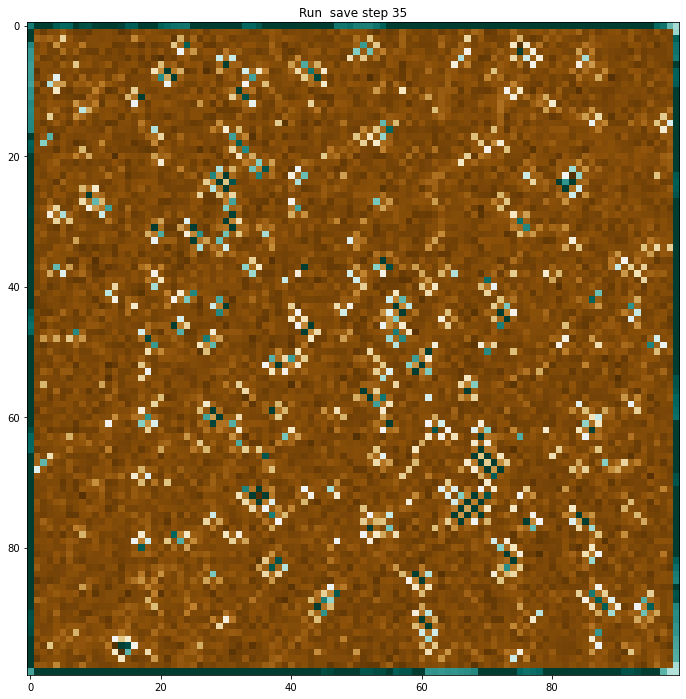

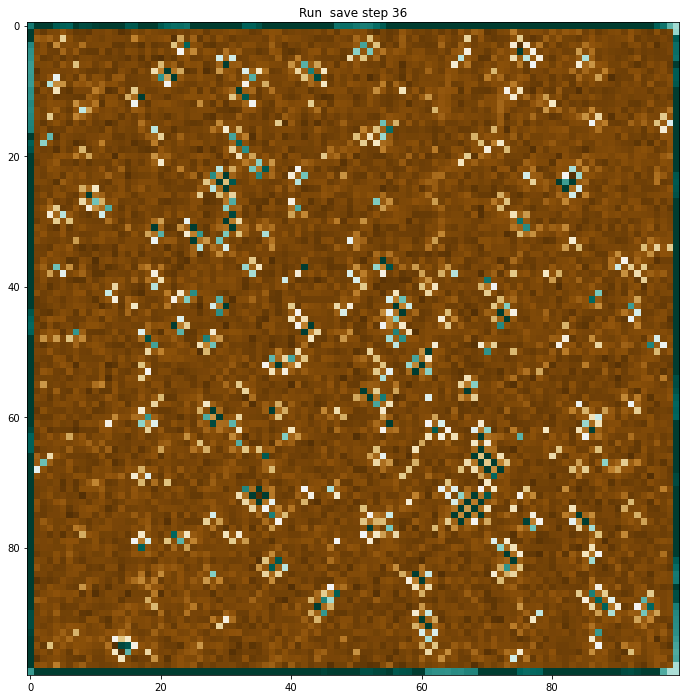

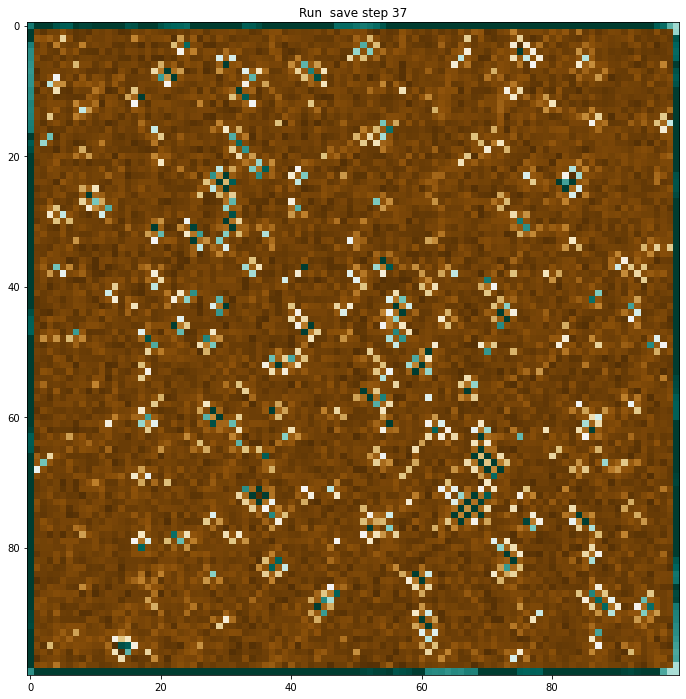

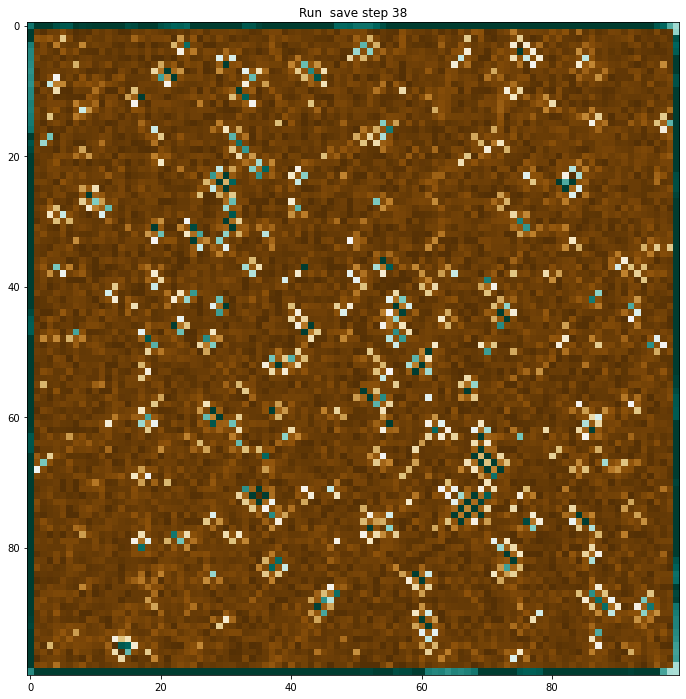

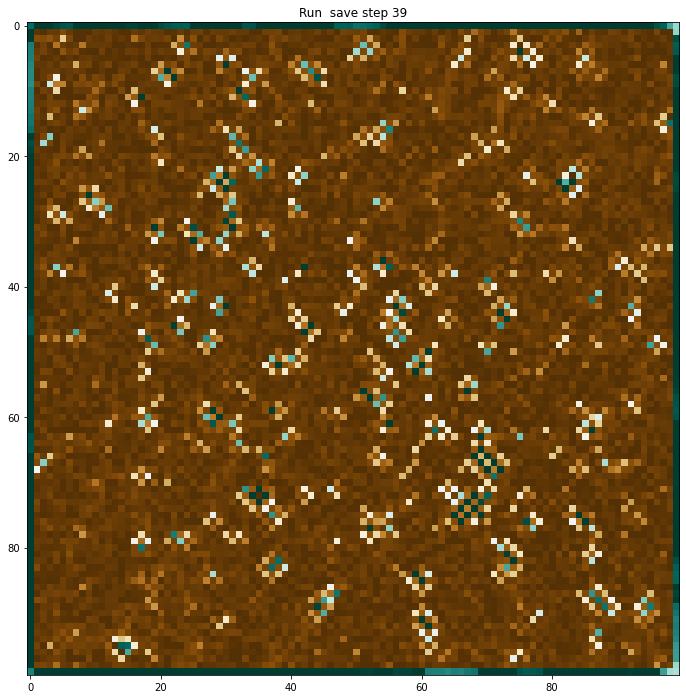

In [23]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i] - all_gravel[0]# + all_rock[i]
    ax.imshow(tmp, cmap=plt.cm.BrBG, vmin=-20, vmax=20)

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

#     alphas = all_waters[i] / 20
#     alphas[alphas > 1] = 1
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)

In [14]:
water.sum()

NameError: name 'water' is not defined

In [ ]:
len(zland.flatten())